# Synthetic data generation

In [1]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [2]:
import pandas as pd

In [3]:
from synthesized.core import BasicSynthesizer

Instructions for updating:
Use the retry module or similar alternatives.


## Load transactions

In [4]:
data = pd.read_csv('../data/transactions.csv')
data.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


## Clean dataset

* Leave target columns only (so far: type, operation, amount)
* Filter NaN values
* Convert columns to appropriate type

In [5]:
data = data[['type', 'operation', 'amount']]
data = data.dropna()
data = data[data['type'] != 'VYBER']
data['type'] = data['type'].astype(dtype='int')
data['type'] = data['type'].astype(dtype='category')
data['operation'] = data['operation'].astype(dtype='int')
data['operation'] = data['operation'].astype(dtype='category')
data['amount'] = data['amount'].astype(dtype='float32')
data.head(10)

,type,operation,amount
0,1,2,700.0
1,1,2,7268.0
2,1,2,14440.0
3,1,2,49752.0
4,1,2,21899.0
5,0,3,34700.0
7,1,2,30192.0
8,0,0,9612.0
9,1,2,31038.0
10,0,3,25200.0


## Train model and synthesized data

In [6]:
with BasicSynthesizer(
    dtypes=data.dtypes,
    encoding='variational', encoding_size=32, encoder=(32,), decoder=(32,)
) as synthesizer:
    synthesizer.learn(data=data, verbose=True)
    synthesized = synthesizer.synthesize(n=10000)

1: 1.52e+08
2: 1.15e+08
3: 1.57e+08
4: 1.82e+08
5: 1.05e+08
6: 1.90e+08
7: 3.02e+08
8: 2.11e+08
9: 8.87e+07
10: 2.83e+08
11: 1.82e+08
12: 8.18e+07
13: 1.67e+08
14: 1.12e+08
15: 1.35e+08
16: 2.15e+08
17: 2.12e+08
18: 1.27e+08
19: 6.47e+07
20: 2.76e+08
21: 1.26e+08
22: 2.93e+08
23: 1.44e+08
24: 5.00e+07
25: 1.23e+08
26: 1.00e+08
27: 9.99e+07
28: 1.66e+08
29: 2.19e+08
30: 1.50e+08
31: 7.07e+07
32: 2.15e+08
33: 1.92e+08
34: 1.27e+08
35: 1.53e+08
36: 1.41e+08
37: 8.50e+07
38: 2.38e+08
39: 1.31e+08
40: 1.13e+08
41: 9.96e+07
42: 1.87e+08
43: 1.21e+08
44: 9.57e+07
45: 8.86e+07
46: 1.38e+08
47: 1.62e+08
48: 1.31e+08
49: 1.61e+08
50: 6.72e+07
51: 1.00e+08
52: 9.45e+07
53: 2.27e+08
54: 8.65e+07
55: 1.22e+08
56: 4.19e+07
57: 7.11e+07
58: 1.51e+08
59: 8.97e+07
60: 1.01e+08
61: 1.73e+08
62: 3.05e+08
63: 1.33e+08
64: 1.03e+08
65: 7.47e+07
66: 2.23e+08
67: 8.08e+07
68: 2.30e+08
69: 2.00e+08
70: 2.03e+08
71: 1.10e+08
72: 2.59e+08
73: 1.98e+08
74: 1.13e+08
75: 1.67e+08
76: 2.04e+08
77: 1.38e+08
78: 7.13

612: 5.83e+07
613: 2.04e+08
614: 8.32e+07
615: 1.49e+08
616: 1.00e+08
617: 1.44e+08
618: 9.01e+07
619: 2.07e+08
620: 1.45e+08
621: 1.47e+08
622: 2.58e+08
623: 2.08e+08
624: 1.01e+08
625: 2.01e+08
626: 2.01e+08
627: 1.90e+08
628: 1.72e+08
629: 1.23e+08
630: 1.30e+08
631: 2.44e+08
632: 1.63e+08
633: 1.36e+08
634: 1.17e+08
635: 2.11e+08
636: 1.06e+08
637: 2.26e+08
638: 7.80e+07
639: 2.05e+08
640: 3.09e+08
641: 2.27e+08
642: 1.12e+08
643: 2.09e+08
644: 2.53e+08
645: 1.47e+08
646: 1.15e+08
647: 7.09e+07
648: 1.30e+08
649: 1.76e+08
650: 2.16e+08
651: 8.78e+07
652: 1.74e+08
653: 2.21e+08
654: 1.22e+08
655: 1.29e+08
656: 1.54e+08
657: 1.83e+08
658: 8.64e+07
659: 1.53e+08
660: 2.15e+08
661: 2.35e+08
662: 1.44e+08
663: 7.62e+07
664: 1.75e+08
665: 1.74e+08
666: 1.38e+08
667: 2.08e+08
668: 2.58e+08
669: 1.20e+08
670: 1.15e+08
671: 1.45e+08
672: 1.02e+08
673: 1.43e+08
674: 8.64e+07
675: 9.31e+07
676: 2.13e+08
677: 4.62e+07
678: 9.80e+07
679: 1.05e+08
680: 1.58e+08
681: 1.14e+08
682: 1.70e+08
683: 9

1247: 1.20e+08
1248: 8.66e+07
1249: 7.53e+07
1250: 1.34e+08
1251: 2.69e+08
1252: 1.25e+08
1253: 1.20e+08
1254: 1.15e+08
1255: 1.38e+08
1256: 1.30e+08
1257: 3.32e+08
1258: 1.24e+08
1259: 1.65e+08
1260: 1.22e+08
1261: 7.51e+07
1262: 1.10e+08
1263: 1.45e+08
1264: 1.65e+08
1265: 1.94e+08
1266: 1.01e+08
1267: 3.11e+07
1268: 1.26e+08
1269: 6.23e+07
1270: 9.97e+07
1271: 7.36e+07
1272: 1.39e+08
1273: 4.38e+07
1274: 2.16e+08
1275: 7.11e+07
1276: 1.22e+08
1277: 2.64e+08
1278: 1.63e+08
1279: 1.42e+08
1280: 1.27e+08
1281: 1.91e+08
1282: 1.69e+08
1283: 1.44e+08
1284: 1.77e+08
1285: 1.63e+08
1286: 1.37e+08
1287: 1.69e+08
1288: 9.38e+07
1289: 7.20e+07
1290: 1.55e+08
1291: 2.06e+08
1292: 7.46e+07
1293: 2.28e+08
1294: 1.27e+08
1295: 1.26e+08
1296: 1.75e+08
1297: 1.51e+08
1298: 1.15e+08
1299: 2.37e+08
1300: 1.28e+08
1301: 1.41e+08
1302: 1.92e+08
1303: 1.83e+08
1304: 2.06e+08
1305: 1.63e+08
1306: 1.61e+08
1307: 2.70e+08
1308: 1.61e+08
1309: 1.98e+08
1310: 2.42e+08
1311: 9.52e+07
1312: 1.86e+08
1313: 1.08

1831: 1.25e+08
1832: 1.86e+08
1833: 9.83e+07
1834: 1.76e+08
1835: 2.26e+08
1836: 1.75e+08
1837: 1.27e+08
1838: 1.76e+08
1839: 7.14e+07
1840: 3.33e+08
1841: 1.81e+08
1842: 7.10e+07
1843: 1.13e+08
1844: 6.51e+07
1845: 5.40e+07
1846: 1.91e+08
1847: 8.01e+07
1848: 1.26e+08
1849: 1.31e+08
1850: 2.51e+08
1851: 1.51e+08
1852: 1.03e+08
1853: 1.01e+08
1854: 2.48e+08
1855: 9.52e+07
1856: 1.52e+08
1857: 1.33e+08
1858: 1.68e+08
1859: 1.29e+08
1860: 1.13e+08
1861: 1.53e+08
1862: 1.46e+08
1863: 1.06e+08
1864: 1.21e+08
1865: 1.42e+08
1866: 8.65e+07
1867: 1.04e+08
1868: 2.38e+08
1869: 1.63e+08
1870: 1.04e+08
1871: 1.70e+08
1872: 1.87e+08
1873: 1.77e+08
1874: 1.53e+08
1875: 1.84e+08
1876: 1.92e+08
1877: 2.08e+08
1878: 1.75e+08
1879: 1.66e+08
1880: 1.50e+08
1881: 1.12e+08
1882: 2.29e+08
1883: 1.11e+08
1884: 8.72e+07
1885: 1.32e+08
1886: 1.76e+08
1887: 8.34e+07
1888: 8.81e+07
1889: 2.01e+08
1890: 1.43e+08
1891: 1.25e+08
1892: 1.19e+08
1893: 7.95e+07
1894: 1.02e+08
1895: 1.16e+08
1896: 1.51e+08
1897: 1.38

2432: 1.05e+08
2433: 1.38e+08
2434: 7.73e+07
2435: 1.78e+08
2436: 1.24e+08
2437: 1.88e+08
2438: 9.80e+07
2439: 7.09e+07
2440: 1.54e+08
2441: 1.82e+08
2442: 2.58e+08
2443: 1.29e+08
2444: 1.09e+08
2445: 1.58e+08
2446: 1.14e+08
2447: 2.08e+08
2448: 2.79e+08
2449: 2.38e+08
2450: 1.44e+08
2451: 3.09e+08
2452: 1.88e+08
2453: 1.75e+08
2454: 1.95e+08
2455: 1.58e+08
2456: 8.02e+07
2457: 1.35e+08
2458: 2.00e+08
2459: 1.28e+08
2460: 2.08e+08
2461: 1.23e+08
2462: 1.30e+08
2463: 2.26e+08
2464: 1.94e+08
2465: 1.48e+08
2466: 1.54e+08
2467: 7.93e+07
2468: 1.04e+08
2469: 1.65e+08
2470: 8.75e+07
2471: 1.60e+08
2472: 1.01e+08
2473: 1.67e+08
2474: 9.81e+07
2475: 2.18e+08
2476: 3.28e+07
2477: 2.15e+08
2478: 2.12e+08
2479: 1.44e+08
2480: 1.35e+08
2481: 1.31e+08
2482: 1.49e+08
2483: 1.12e+08
2484: 1.96e+08
2485: 1.26e+08
2486: 1.14e+08
2487: 1.39e+08
2488: 1.23e+08
2489: 1.02e+08
2490: 1.66e+08
2491: 1.14e+08
2492: 2.67e+08
2493: 1.77e+08
2494: 7.01e+07
2495: 1.56e+08
2496: 1.06e+08
2497: 2.86e+08
2498: 2.41

3036: 9.93e+07
3037: 1.79e+08
3038: 1.58e+08
3039: 1.23e+08
3040: 1.24e+08
3041: 2.19e+08
3042: 1.49e+08
3043: 8.46e+07
3044: 1.40e+08
3045: 2.30e+08
3046: 2.19e+08
3047: 1.06e+08
3048: 1.17e+08
3049: 1.68e+08
3050: 1.27e+08
3051: 9.52e+07
3052: 1.29e+08
3053: 1.34e+08
3054: 1.13e+08
3055: 2.11e+08
3056: 2.39e+08
3057: 1.53e+08
3058: 1.21e+08
3059: 1.95e+08
3060: 1.09e+08
3061: 1.37e+08
3062: 1.57e+08
3063: 1.49e+08
3064: 2.00e+08
3065: 1.02e+08
3066: 1.36e+08
3067: 1.75e+08
3068: 1.66e+08
3069: 2.07e+08
3070: 8.31e+07
3071: 1.05e+08
3072: 1.81e+08
3073: 2.30e+08
3074: 1.18e+08
3075: 2.68e+08
3076: 2.28e+08
3077: 1.97e+08
3078: 8.95e+07
3079: 1.09e+08
3080: 1.63e+08
3081: 2.66e+08
3082: 1.57e+08
3083: 1.20e+08
3084: 1.49e+08
3085: 1.11e+08
3086: 2.12e+08
3087: 1.44e+08
3088: 1.40e+08
3089: 6.70e+07
3090: 1.45e+08
3091: 1.39e+08
3092: 1.38e+08
3093: 1.65e+08
3094: 1.84e+08
3095: 1.46e+08
3096: 7.66e+07
3097: 1.82e+08
3098: 2.63e+08
3099: 6.24e+07
3100: 2.03e+08
3101: 1.66e+08
3102: 1.57

3610: 7.63e+07
3611: 7.67e+07
3612: 1.93e+08
3613: 1.85e+08
3614: 1.35e+08
3615: 1.99e+08
3616: 1.85e+08
3617: 8.88e+07
3618: 1.29e+08
3619: 2.05e+08
3620: 1.55e+08
3621: 1.16e+08
3622: 1.08e+08
3623: 1.28e+08
3624: 1.32e+08
3625: 1.69e+08
3626: 2.63e+08
3627: 1.85e+08
3628: 1.79e+08
3629: 2.22e+08
3630: 1.82e+08
3631: 1.96e+08
3632: 1.58e+08
3633: 1.19e+08
3634: 1.83e+08
3635: 1.92e+08
3636: 1.04e+08
3637: 1.13e+08
3638: 1.49e+08
3639: 2.06e+08
3640: 2.31e+08
3641: 2.38e+08
3642: 1.11e+08
3643: 4.42e+07
3644: 7.19e+07
3645: 1.49e+08
3646: 9.74e+07
3647: 1.52e+08
3648: 1.56e+08
3649: 2.66e+08
3650: 1.72e+08
3651: 1.97e+08
3652: 8.29e+07
3653: 1.42e+08
3654: 1.47e+08
3655: 1.03e+08
3656: 1.61e+08
3657: 1.77e+08
3658: 1.65e+08
3659: 8.68e+07
3660: 2.59e+08
3661: 1.84e+08
3662: 2.41e+08
3663: 2.61e+08
3664: 1.63e+08
3665: 1.56e+08
3666: 8.88e+07
3667: 1.08e+08
3668: 1.48e+08
3669: 2.32e+08
3670: 1.75e+08
3671: 2.37e+08
3672: 1.57e+08
3673: 1.59e+08
3674: 8.62e+07
3675: 1.31e+08
3676: 1.21

4227: 1.82e+08
4228: 1.19e+08
4229: 1.44e+08
4230: 1.12e+08
4231: 1.73e+08
4232: 8.71e+07
4233: 1.51e+08
4234: 3.01e+08
4235: 1.97e+08
4236: 1.40e+08
4237: 8.38e+07
4238: 7.85e+07
4239: 1.48e+08
4240: 8.99e+07
4241: 2.04e+08
4242: 1.79e+08
4243: 1.44e+08
4244: 1.58e+08
4245: 1.72e+08
4246: 2.12e+08
4247: 1.57e+08
4248: 1.07e+08
4249: 1.60e+08
4250: 2.13e+08
4251: 1.30e+08
4252: 1.79e+08
4253: 1.68e+08
4254: 1.16e+08
4255: 2.23e+08
4256: 1.09e+08
4257: 1.34e+08
4258: 1.17e+08
4259: 1.35e+08
4260: 2.99e+08
4261: 1.95e+08
4262: 1.31e+08
4263: 1.20e+08
4264: 1.04e+08
4265: 1.47e+08
4266: 1.07e+08
4267: 9.86e+07
4268: 2.32e+08
4269: 9.81e+07
4270: 1.15e+08
4271: 2.61e+08
4272: 1.76e+08
4273: 2.50e+08
4274: 1.92e+08
4275: 3.22e+08
4276: 4.23e+07
4277: 1.06e+08
4278: 2.17e+08
4279: 1.02e+08
4280: 1.66e+08
4281: 1.69e+08
4282: 2.10e+08
4283: 1.23e+08
4284: 1.09e+08
4285: 1.09e+08
4286: 1.02e+08
4287: 1.75e+08
4288: 1.40e+08
4289: 8.37e+07
4290: 2.35e+08
4291: 9.95e+07
4292: 1.09e+08
4293: 1.72

4790: 1.03e+08
4791: 1.80e+08
4792: 2.15e+08
4793: 1.97e+08
4794: 5.46e+07
4795: 1.44e+08
4796: 1.52e+08
4797: 9.99e+07
4798: 2.28e+08
4799: 1.98e+08
4800: 3.20e+08
4801: 1.37e+08
4802: 1.39e+08
4803: 2.21e+08
4804: 8.53e+07
4805: 7.38e+07
4806: 2.08e+08
4807: 1.30e+08
4808: 2.36e+08
4809: 1.44e+08
4810: 8.56e+07
4811: 1.36e+08
4812: 1.60e+08
4813: 1.04e+08
4814: 1.11e+08
4815: 1.24e+08
4816: 1.21e+08
4817: 6.58e+07
4818: 1.23e+08
4819: 2.04e+08
4820: 1.26e+08
4821: 8.67e+07
4822: 2.43e+08
4823: 1.87e+08
4824: 2.38e+08
4825: 6.44e+07
4826: 1.48e+08
4827: 6.12e+07
4828: 5.68e+07
4829: 1.25e+08
4830: 9.57e+07
4831: 1.45e+08
4832: 1.23e+08
4833: 1.85e+08
4834: 1.97e+08
4835: 1.46e+08
4836: 1.39e+08
4837: 1.70e+08
4838: 1.27e+08
4839: 1.44e+08
4840: 1.42e+08
4841: 1.26e+08
4842: 1.83e+08
4843: 1.36e+08
4844: 1.15e+08
4845: 9.18e+07
4846: 1.64e+08
4847: 1.13e+08
4848: 2.17e+08
4849: 1.70e+08
4850: 6.22e+07
4851: 1.60e+08
4852: 2.58e+08
4853: 1.49e+08
4854: 9.14e+07
4855: 2.24e+08
4856: 2.12

5347: 1.21e+08
5348: 2.03e+08
5349: 1.55e+08
5350: 1.51e+08
5351: 1.25e+08
5352: 7.26e+07
5353: 2.65e+08
5354: 8.59e+07
5355: 1.77e+08
5356: 1.55e+08
5357: 1.05e+08
5358: 2.13e+08
5359: 1.28e+08
5360: 1.50e+08
5361: 1.16e+08
5362: 1.25e+08
5363: 8.64e+07
5364: 6.19e+07
5365: 1.14e+08
5366: 9.12e+07
5367: 1.69e+08
5368: 1.79e+08
5369: 7.31e+07
5370: 1.32e+08
5371: 1.54e+08
5372: 9.84e+07
5373: 1.12e+08
5374: 1.11e+08
5375: 1.60e+08
5376: 6.56e+07
5377: 8.89e+07
5378: 1.88e+08
5379: 1.99e+08
5380: 1.41e+08
5381: 1.04e+08
5382: 1.36e+08
5383: 2.53e+08
5384: 1.86e+08
5385: 1.08e+08
5386: 1.37e+08
5387: 1.18e+08
5388: 6.47e+07
5389: 1.85e+08
5390: 2.75e+08
5391: 4.66e+07
5392: 1.24e+08
5393: 1.22e+08
5394: 1.50e+08
5395: 2.16e+08
5396: 1.12e+08
5397: 2.45e+08
5398: 6.78e+07
5399: 1.71e+08
5400: 1.50e+08
5401: 1.28e+08
5402: 4.62e+07
5403: 1.82e+08
5404: 7.77e+07
5405: 1.17e+08
5406: 1.41e+08
5407: 1.86e+08
5408: 1.29e+08
5409: 8.28e+07
5410: 1.45e+08
5411: 1.79e+08
5412: 9.86e+07
5413: 1.41

6003: 1.30e+08
6004: 1.90e+08
6005: 1.48e+08
6006: 1.77e+08
6007: 7.83e+07
6008: 2.04e+08
6009: 2.24e+08
6010: 3.66e+08
6011: 1.63e+08
6012: 1.63e+08
6013: 9.33e+07
6014: 1.68e+08
6015: 2.13e+08
6016: 9.25e+07
6017: 1.05e+08
6018: 2.03e+08
6019: 1.51e+08
6020: 1.09e+08
6021: 1.30e+08
6022: 1.56e+08
6023: 1.70e+08
6024: 7.73e+07
6025: 1.20e+08
6026: 1.49e+08
6027: 1.57e+08
6028: 2.10e+08
6029: 1.41e+08
6030: 1.64e+08
6031: 1.21e+08
6032: 1.47e+08
6033: 1.48e+08
6034: 2.21e+08
6035: 1.09e+08
6036: 1.63e+08
6037: 1.25e+08
6038: 1.21e+08
6039: 1.45e+08
6040: 7.47e+07
6041: 1.30e+08
6042: 1.72e+08
6043: 1.87e+08
6044: 1.45e+08
6045: 1.42e+08
6046: 2.05e+08
6047: 9.98e+07
6048: 1.05e+08
6049: 1.65e+08
6050: 8.60e+07
6051: 1.01e+08
6052: 1.99e+08
6053: 1.15e+08
6054: 1.82e+08
6055: 2.27e+08
6056: 1.46e+08
6057: 1.51e+08
6058: 7.51e+07
6059: 2.40e+08
6060: 1.33e+08
6061: 2.28e+08
6062: 1.08e+08
6063: 1.23e+08
6064: 1.30e+08
6065: 1.29e+08
6066: 1.80e+08
6067: 1.38e+08
6068: 1.82e+08
6069: 1.19

6583: 2.23e+08
6584: 1.66e+08
6585: 1.97e+08
6586: 1.87e+08
6587: 1.66e+08
6588: 1.06e+08
6589: 1.14e+08
6590: 2.14e+08
6591: 1.38e+08
6592: 2.02e+08
6593: 1.63e+08
6594: 1.88e+08
6595: 1.37e+08
6596: 1.17e+08
6597: 1.37e+08
6598: 1.69e+08
6599: 1.40e+08
6600: 8.47e+07
6601: 1.32e+08
6602: 1.65e+08
6603: 1.55e+08
6604: 2.12e+08
6605: 2.48e+08
6606: 1.48e+08
6607: 8.82e+07
6608: 1.65e+08
6609: 1.70e+08
6610: 2.00e+08
6611: 1.29e+08
6612: 1.34e+08
6613: 2.11e+08
6614: 2.54e+08
6615: 3.22e+08
6616: 1.90e+08
6617: 2.39e+08
6618: 4.62e+07
6619: 1.20e+08
6620: 9.62e+07
6621: 1.30e+08
6622: 1.26e+08
6623: 8.68e+07
6624: 1.49e+08
6625: 6.82e+07
6626: 1.28e+08
6627: 1.68e+08
6628: 1.70e+08
6629: 1.17e+08
6630: 1.30e+08
6631: 1.62e+08
6632: 1.52e+08
6633: 1.49e+08
6634: 2.07e+08
6635: 1.79e+08
6636: 8.52e+07
6637: 1.68e+08
6638: 2.62e+08
6639: 1.47e+08
6640: 2.36e+08
6641: 1.72e+08
6642: 9.63e+07
6643: 5.74e+07
6644: 1.43e+08
6645: 8.75e+07
6646: 1.75e+08
6647: 1.88e+08
6648: 9.88e+07
6649: 2.02

7225: 1.46e+08
7226: 1.48e+08
7227: 1.97e+08
7228: 1.53e+08
7229: 1.76e+08
7230: 8.62e+07
7231: 1.83e+08
7232: 1.63e+08
7233: 1.48e+08
7234: 1.08e+08
7235: 2.04e+08
7236: 1.25e+08
7237: 1.82e+08
7238: 1.24e+08
7239: 1.83e+08
7240: 1.22e+08
7241: 2.02e+08
7242: 1.21e+08
7243: 2.35e+08
7244: 1.79e+08
7245: 1.78e+08
7246: 9.19e+07
7247: 1.74e+08
7248: 1.64e+08
7249: 1.41e+08
7250: 1.04e+08
7251: 1.97e+08
7252: 1.24e+08
7253: 1.99e+08
7254: 1.07e+08
7255: 1.51e+08
7256: 1.99e+08
7257: 1.95e+08
7258: 1.75e+08
7259: 2.21e+08
7260: 1.20e+08
7261: 1.54e+08
7262: 1.89e+08
7263: 1.33e+08
7264: 2.26e+08
7265: 6.25e+07
7266: 1.31e+08
7267: 1.32e+08
7268: 1.24e+08
7269: 1.28e+08
7270: 7.86e+07
7271: 1.58e+08
7272: 1.10e+08
7273: 1.06e+08
7274: 8.96e+07
7275: 2.13e+08
7276: 1.78e+08
7277: 1.01e+08
7278: 1.03e+08
7279: 1.36e+08
7280: 1.77e+08
7281: 1.55e+08
7282: 1.50e+08
7283: 1.04e+08
7284: 1.06e+08
7285: 1.56e+08
7286: 8.78e+07
7287: 9.14e+07
7288: 1.64e+08
7289: 1.74e+08
7290: 1.93e+08
7291: 1.14

7802: 8.81e+07
7803: 1.61e+08
7804: 2.07e+08
7805: 1.08e+08
7806: 1.37e+08
7807: 1.29e+08
7808: 1.27e+08
7809: 1.64e+08
7810: 1.62e+08
7811: 2.02e+08
7812: 2.12e+08
7813: 1.36e+08
7814: 1.64e+08
7815: 9.12e+07
7816: 1.05e+08
7817: 1.31e+08
7818: 1.14e+08
7819: 2.11e+08
7820: 5.91e+07
7821: 6.21e+07
7822: 2.26e+08
7823: 1.42e+08
7824: 1.51e+08
7825: 1.33e+08
7826: 1.14e+08
7827: 6.53e+07
7828: 1.44e+08
7829: 1.22e+08
7830: 1.70e+08
7831: 1.20e+08
7832: 1.72e+08
7833: 1.41e+08
7834: 1.26e+08
7835: 2.97e+08
7836: 2.06e+08
7837: 2.05e+08
7838: 8.06e+07
7839: 1.70e+08
7840: 1.22e+08
7841: 1.09e+08
7842: 1.44e+08
7843: 1.32e+08
7844: 7.40e+07
7845: 1.24e+08
7846: 1.53e+08
7847: 1.96e+08
7848: 2.46e+08
7849: 1.38e+08
7850: 1.03e+08
7851: 9.55e+07
7852: 1.02e+08
7853: 1.10e+08
7854: 1.02e+08
7855: 1.17e+08
7856: 1.73e+08
7857: 8.16e+07
7858: 1.58e+08
7859: 9.82e+07
7860: 1.80e+08
7861: 5.68e+07
7862: 1.34e+08
7863: 1.69e+08
7864: 2.25e+08
7865: 1.36e+08
7866: 1.63e+08
7867: 9.76e+07
7868: 1.15

8367: 9.04e+07
8368: 1.40e+08
8369: 1.31e+08
8370: 1.96e+08
8371: 1.42e+08
8372: 1.93e+08
8373: 1.96e+08
8374: 1.40e+08
8375: 2.12e+08
8376: 9.66e+07
8377: 9.25e+07
8378: 1.36e+08
8379: 1.47e+08
8380: 1.76e+08
8381: 1.54e+08
8382: 1.23e+08
8383: 1.91e+08
8384: 9.06e+07
8385: 1.13e+08
8386: 1.45e+08
8387: 2.26e+08
8388: 2.54e+08
8389: 1.26e+08
8390: 1.09e+08
8391: 2.19e+08
8392: 1.57e+08
8393: 5.91e+07
8394: 1.98e+08
8395: 1.16e+08
8396: 1.05e+08
8397: 1.73e+08
8398: 8.92e+07
8399: 1.20e+08
8400: 2.87e+08
8401: 1.14e+08
8402: 8.80e+07
8403: 1.63e+08
8404: 8.84e+07
8405: 3.11e+08
8406: 1.37e+08
8407: 1.36e+08
8408: 7.69e+07
8409: 1.60e+08
8410: 1.15e+08
8411: 1.76e+08
8412: 1.05e+08
8413: 6.53e+07
8414: 2.14e+08
8415: 1.23e+08
8416: 6.58e+07
8417: 1.49e+08
8418: 1.83e+08
8419: 6.74e+07
8420: 1.05e+08
8421: 1.11e+08
8422: 1.32e+08
8423: 1.40e+08
8424: 1.17e+08
8425: 9.57e+07
8426: 1.54e+08
8427: 7.26e+07
8428: 8.68e+07
8429: 8.20e+07
8430: 1.70e+08
8431: 2.63e+08
8432: 1.36e+08
8433: 2.00

8959: 2.66e+08
8960: 1.40e+08
8961: 1.69e+08
8962: 2.09e+08
8963: 1.56e+08
8964: 1.44e+08
8965: 2.68e+08
8966: 1.55e+08
8967: 2.17e+08
8968: 3.71e+08
8969: 1.25e+08
8970: 9.45e+07
8971: 2.17e+08
8972: 1.38e+08
8973: 2.02e+08
8974: 1.35e+08
8975: 1.38e+08
8976: 1.13e+08
8977: 1.30e+08
8978: 2.25e+08
8979: 1.03e+08
8980: 1.47e+08
8981: 1.35e+08
8982: 1.14e+08
8983: 1.68e+08
8984: 9.66e+07
8985: 8.18e+07
8986: 1.20e+08
8987: 1.27e+08
8988: 1.27e+08
8989: 1.85e+08
8990: 1.62e+08
8991: 1.40e+08
8992: 1.94e+08
8993: 1.62e+08
8994: 9.63e+07
8995: 1.62e+08
8996: 1.01e+08
8997: 1.42e+08
8998: 1.10e+08
8999: 1.23e+08
9000: 1.87e+08
9001: 1.43e+08
9002: 9.18e+07
9003: 9.25e+07
9004: 1.18e+08
9005: 9.29e+07
9006: 1.53e+08
9007: 1.73e+08
9008: 1.53e+08
9009: 1.07e+08
9010: 1.15e+08
9011: 8.23e+07
9012: 8.91e+07
9013: 7.19e+07
9014: 1.70e+08
9015: 1.96e+08
9016: 1.49e+08
9017: 1.73e+08
9018: 9.66e+07
9019: 1.16e+08
9020: 1.07e+08
9021: 9.53e+07
9022: 1.76e+08
9023: 1.63e+08
9024: 1.39e+08
9025: 1.10

9566: 1.44e+08
9567: 1.09e+08
9568: 4.15e+07
9569: 2.15e+08
9570: 1.43e+08
9571: 1.51e+08
9572: 1.72e+08
9573: 1.39e+08
9574: 1.09e+08
9575: 9.35e+07
9576: 1.45e+08
9577: 1.09e+08
9578: 1.61e+08
9579: 8.06e+07
9580: 1.26e+08
9581: 1.50e+08
9582: 1.33e+08
9583: 1.23e+08
9584: 5.85e+07
9585: 6.24e+07
9586: 1.49e+08
9587: 1.30e+08
9588: 1.63e+08
9589: 1.33e+08
9590: 1.34e+08
9591: 1.73e+08
9592: 9.45e+07
9593: 1.13e+08
9594: 1.73e+08
9595: 1.26e+08
9596: 7.53e+07
9597: 1.50e+08
9598: 5.67e+07
9599: 1.06e+08
9600: 1.36e+08
9601: 1.32e+08
9602: 1.80e+08
9603: 1.31e+08
9604: 2.01e+08
9605: 1.61e+08
9606: 1.96e+08
9607: 9.33e+07
9608: 1.18e+08
9609: 8.60e+07
9610: 1.23e+08
9611: 1.55e+08
9612: 2.15e+08
9613: 1.02e+08
9614: 1.22e+08
9615: 1.82e+08
9616: 1.95e+08
9617: 7.01e+07
9618: 1.36e+08
9619: 1.01e+08
9620: 3.29e+08
9621: 1.67e+08
9622: 1.01e+08
9623: 1.05e+08
9624: 9.07e+07
9625: 1.71e+08
9626: 2.16e+08
9627: 9.53e+07
9628: 1.02e+08
9629: 1.90e+08
9630: 2.96e+08
9631: 2.46e+08
9632: 1.73

10164: 1.91e+08
10165: 1.19e+08
10166: 8.34e+07
10167: 1.52e+08
10168: 2.33e+08
10169: 2.37e+08
10170: 1.94e+08
10171: 6.94e+07
10172: 5.72e+07
10173: 1.66e+08
10174: 1.15e+08
10175: 7.12e+07
10176: 1.77e+08
10177: 1.65e+08
10178: 9.63e+07
10179: 2.71e+08
10180: 1.22e+08
10181: 1.52e+08
10182: 4.53e+07
10183: 2.00e+08
10184: 8.46e+07
10185: 7.18e+07
10186: 1.35e+08
10187: 1.33e+08
10188: 1.41e+08
10189: 1.33e+08
10190: 1.91e+08
10191: 1.72e+08
10192: 1.82e+08
10193: 1.03e+08
10194: 1.99e+08
10195: 1.17e+08
10196: 2.58e+08
10197: 1.32e+08
10198: 1.38e+08
10199: 2.03e+08
10200: 1.28e+08
10201: 6.62e+07
10202: 1.72e+08
10203: 2.15e+08
10204: 1.04e+08
10205: 8.16e+07
10206: 1.50e+08
10207: 1.46e+08
10208: 5.49e+07
10209: 9.83e+07
10210: 1.43e+08
10211: 1.78e+08
10212: 9.44e+07
10213: 1.33e+08
10214: 1.40e+08
10215: 2.04e+08
10216: 1.33e+08
10217: 1.50e+08
10218: 1.12e+08
10219: 1.37e+08
10220: 1.43e+08
10221: 9.51e+07
10222: 5.01e+07
10223: 2.06e+08
10224: 1.19e+08
10225: 2.47e+08
10226: 2

10707: 2.06e+08
10708: 1.92e+08
10709: 1.70e+08
10710: 1.29e+08
10711: 8.35e+07
10712: 1.49e+08
10713: 1.01e+08
10714: 1.41e+08
10715: 1.49e+08
10716: 1.82e+08
10717: 8.20e+07
10718: 1.83e+08
10719: 1.65e+08
10720: 2.62e+08
10721: 1.04e+08
10722: 1.37e+08
10723: 1.03e+08
10724: 1.54e+08
10725: 1.52e+08
10726: 1.35e+08
10727: 1.14e+08
10728: 1.29e+08
10729: 8.24e+07
10730: 9.92e+07
10731: 1.41e+08
10732: 9.50e+07
10733: 1.55e+08
10734: 1.52e+08
10735: 9.42e+07
10736: 9.39e+07
10737: 4.46e+07
10738: 1.06e+08
10739: 1.48e+08
10740: 2.01e+08
10741: 2.24e+08
10742: 2.11e+08
10743: 1.09e+08
10744: 1.65e+08
10745: 1.16e+08
10746: 2.78e+08
10747: 1.93e+08
10748: 7.96e+07
10749: 1.23e+08
10750: 1.43e+08
10751: 6.82e+07
10752: 2.99e+08
10753: 4.57e+07
10754: 1.36e+08
10755: 9.87e+07
10756: 1.90e+08
10757: 1.59e+08
10758: 3.45e+07
10759: 1.14e+08
10760: 1.83e+08
10761: 1.59e+08
10762: 1.36e+08
10763: 1.48e+08
10764: 1.09e+08
10765: 1.70e+08
10766: 1.30e+08
10767: 1.65e+08
10768: 1.21e+08
10769: 1

11285: 9.15e+07
11286: 1.45e+08
11287: 8.99e+07
11288: 7.20e+07
11289: 9.89e+07
11290: 2.08e+08
11291: 1.77e+08
11292: 1.66e+08
11293: 8.53e+07
11294: 1.11e+08
11295: 1.63e+08
11296: 2.21e+08
11297: 9.87e+07
11298: 1.20e+08
11299: 1.19e+08
11300: 2.03e+08
11301: 2.37e+08
11302: 9.97e+07
11303: 1.66e+08
11304: 1.05e+08
11305: 2.10e+08
11306: 2.00e+08
11307: 8.99e+07
11308: 2.26e+08
11309: 8.22e+07
11310: 1.33e+08
11311: 1.13e+08
11312: 1.59e+08
11313: 2.22e+08
11314: 8.80e+07
11315: 1.86e+08
11316: 7.77e+07
11317: 2.01e+08
11318: 1.44e+08
11319: 1.04e+08
11320: 1.07e+08
11321: 1.66e+08
11322: 9.26e+07
11323: 1.12e+08
11324: 1.30e+08
11325: 1.68e+08
11326: 7.81e+07
11327: 1.13e+08
11328: 1.21e+08
11329: 1.50e+08
11330: 1.64e+08
11331: 1.85e+08
11332: 8.69e+07
11333: 1.16e+08
11334: 1.28e+08
11335: 8.43e+07
11336: 1.29e+08
11337: 6.02e+07
11338: 2.50e+08
11339: 2.42e+08
11340: 5.13e+07
11341: 1.12e+08
11342: 8.15e+07
11343: 1.09e+08
11344: 1.18e+08
11345: 9.92e+07
11346: 2.48e+08
11347: 6

11815: 2.07e+08
11816: 2.49e+08
11817: 1.16e+08
11818: 1.86e+08
11819: 2.31e+08
11820: 1.15e+08
11821: 7.84e+07
11822: 1.55e+08
11823: 1.67e+08
11824: 1.16e+08
11825: 9.89e+07
11826: 1.95e+08
11827: 2.09e+08
11828: 1.66e+08
11829: 1.40e+08
11830: 7.44e+07
11831: 2.00e+08
11832: 1.54e+08
11833: 1.52e+08
11834: 1.44e+08
11835: 1.58e+08
11836: 1.23e+08
11837: 9.32e+07
11838: 5.36e+07
11839: 1.85e+08
11840: 7.53e+07
11841: 1.01e+08
11842: 1.85e+08
11843: 8.02e+07
11844: 1.34e+08
11845: 1.09e+08
11846: 1.01e+08
11847: 1.33e+08
11848: 9.72e+07
11849: 1.36e+08
11850: 1.91e+08
11851: 2.20e+08
11852: 1.52e+08
11853: 8.90e+07
11854: 1.08e+08
11855: 1.71e+08
11856: 6.94e+07
11857: 1.36e+08
11858: 1.16e+08
11859: 1.85e+08
11860: 7.83e+07
11861: 3.02e+08
11862: 1.71e+08
11863: 1.43e+08
11864: 1.21e+08
11865: 1.84e+08
11866: 2.25e+08
11867: 1.67e+08
11868: 4.94e+07
11869: 1.49e+08
11870: 1.39e+08
11871: 9.92e+07
11872: 1.16e+08
11873: 1.02e+08
11874: 2.19e+08
11875: 2.30e+08
11876: 8.61e+07
11877: 1

12355: 1.31e+08
12356: 1.28e+08
12357: 8.47e+07
12358: 2.06e+08
12359: 9.56e+07
12360: 1.10e+08
12361: 1.36e+08
12362: 1.61e+08
12363: 9.19e+07
12364: 9.01e+07
12365: 1.41e+08
12366: 1.45e+08
12367: 1.02e+08
12368: 1.97e+08
12369: 1.43e+08
12370: 1.43e+08
12371: 1.19e+08
12372: 1.34e+08
12373: 2.05e+08
12374: 1.41e+08
12375: 2.13e+08
12376: 1.19e+08
12377: 1.21e+08
12378: 1.81e+08
12379: 1.27e+08
12380: 7.99e+07
12381: 2.18e+08
12382: 1.31e+08
12383: 1.52e+08
12384: 1.39e+08
12385: 1.34e+08
12386: 1.89e+08
12387: 1.71e+08
12388: 1.34e+08
12389: 1.81e+08
12390: 1.75e+08
12391: 1.35e+08
12392: 9.92e+07
12393: 3.12e+08
12394: 1.84e+08
12395: 1.61e+08
12396: 1.87e+08
12397: 1.50e+08
12398: 1.17e+08
12399: 1.15e+08
12400: 1.67e+08
12401: 2.23e+08
12402: 1.42e+08
12403: 1.44e+08
12404: 1.78e+08
12405: 1.09e+08
12406: 1.87e+08
12407: 1.52e+08
12408: 1.26e+08
12409: 1.04e+08
12410: 1.35e+08
12411: 9.98e+07
12412: 1.67e+08
12413: 1.43e+08
12414: 7.70e+07
12415: 5.20e+07
12416: 2.20e+08
12417: 1

12933: 1.73e+08
12934: 1.61e+08
12935: 1.47e+08
12936: 1.20e+08
12937: 1.77e+08
12938: 9.40e+07
12939: 1.03e+08
12940: 2.57e+08
12941: 1.09e+08
12942: 1.48e+08
12943: 1.11e+08
12944: 2.93e+08
12945: 1.42e+08
12946: 7.30e+07
12947: 8.06e+07
12948: 8.91e+07
12949: 1.31e+08
12950: 1.33e+08
12951: 6.73e+07
12952: 1.96e+08
12953: 6.97e+07
12954: 1.10e+08
12955: 1.91e+08
12956: 1.08e+08
12957: 2.11e+08
12958: 2.40e+08
12959: 1.51e+08
12960: 9.88e+07
12961: 4.73e+07
12962: 1.86e+08
12963: 1.09e+08
12964: 1.97e+08
12965: 6.60e+07
12966: 1.14e+08
12967: 1.49e+08
12968: 2.11e+08
12969: 9.69e+07
12970: 6.00e+07
12971: 1.38e+08
12972: 1.46e+08
12973: 2.32e+08
12974: 9.15e+07
12975: 7.01e+07
12976: 1.69e+08
12977: 7.74e+07
12978: 9.85e+07
12979: 1.58e+08
12980: 1.26e+08
12981: 2.17e+08
12982: 1.76e+08
12983: 4.58e+07
12984: 1.44e+08
12985: 1.04e+08
12986: 1.30e+08
12987: 1.38e+08
12988: 1.59e+08
12989: 1.75e+08
12990: 1.29e+08
12991: 9.09e+07
12992: 1.33e+08
12993: 5.11e+07
12994: 8.99e+07
12995: 1

13513: 1.63e+08
13514: 1.25e+08
13515: 7.80e+07
13516: 1.49e+08
13517: 1.36e+08
13518: 7.26e+07
13519: 9.80e+07
13520: 1.47e+08
13521: 8.94e+07
13522: 1.42e+08
13523: 8.57e+07
13524: 1.36e+08
13525: 1.95e+08
13526: 1.00e+08
13527: 8.06e+07
13528: 1.49e+08
13529: 1.71e+08
13530: 1.96e+08
13531: 1.86e+08
13532: 1.04e+08
13533: 1.49e+08
13534: 2.32e+08
13535: 1.66e+08
13536: 1.11e+08
13537: 1.72e+08
13538: 1.08e+08
13539: 1.10e+08
13540: 8.98e+07
13541: 1.68e+08
13542: 1.64e+08
13543: 1.21e+08
13544: 6.94e+07
13545: 7.43e+07
13546: 1.31e+08
13547: 1.49e+08
13548: 1.17e+08
13549: 1.87e+08
13550: 8.68e+07
13551: 1.57e+08
13552: 1.34e+08
13553: 4.85e+07
13554: 1.37e+08
13555: 2.33e+08
13556: 1.18e+08
13557: 7.93e+07
13558: 1.21e+08
13559: 9.18e+07
13560: 1.48e+08
13561: 1.91e+08
13562: 1.17e+08
13563: 8.81e+07
13564: 1.60e+08
13565: 1.54e+08
13566: 8.23e+07
13567: 1.19e+08
13568: 8.59e+07
13569: 1.38e+08
13570: 9.03e+07
13571: 1.26e+08
13572: 1.41e+08
13573: 1.39e+08
13574: 8.83e+07
13575: 1

14087: 1.76e+08
14088: 1.33e+08
14089: 1.09e+08
14090: 2.30e+08
14091: 4.32e+07
14092: 2.13e+08
14093: 2.12e+08
14094: 1.18e+08
14095: 1.27e+08
14096: 1.78e+08
14097: 1.13e+08
14098: 1.05e+08
14099: 8.04e+07
14100: 1.56e+08
14101: 1.68e+08
14102: 2.48e+08
14103: 1.07e+08
14104: 1.70e+08
14105: 1.15e+08
14106: 1.12e+08
14107: 7.77e+07
14108: 9.78e+07
14109: 1.51e+08
14110: 1.14e+08
14111: 8.33e+07
14112: 8.90e+07
14113: 1.86e+08
14114: 1.14e+08
14115: 1.32e+08
14116: 2.12e+08
14117: 1.51e+08
14118: 1.24e+08
14119: 1.16e+08
14120: 6.16e+07
14121: 1.15e+08
14122: 1.77e+08
14123: 1.52e+08
14124: 8.73e+07
14125: 1.25e+08
14126: 1.34e+08
14127: 9.69e+07
14128: 1.42e+08
14129: 6.93e+07
14130: 1.13e+08
14131: 1.42e+08
14132: 1.32e+08
14133: 1.80e+08
14134: 5.65e+07
14135: 1.19e+08
14136: 2.41e+08
14137: 1.19e+08
14138: 1.77e+08
14139: 1.35e+08
14140: 1.26e+08
14141: 1.40e+08
14142: 1.46e+08
14143: 2.39e+08
14144: 1.29e+08
14145: 1.45e+08
14146: 1.26e+08
14147: 1.22e+08
14148: 1.66e+08
14149: 4

14652: 9.66e+07
14653: 1.66e+08
14654: 1.28e+08
14655: 1.04e+08
14656: 1.78e+08
14657: 4.20e+07
14658: 2.19e+08
14659: 2.24e+08
14660: 1.53e+08
14661: 1.03e+08
14662: 1.68e+08
14663: 1.06e+08
14664: 1.66e+08
14665: 9.56e+07
14666: 2.33e+08
14667: 5.85e+07
14668: 1.70e+08
14669: 6.04e+07
14670: 1.09e+08
14671: 1.08e+08
14672: 1.28e+08
14673: 9.33e+07
14674: 9.16e+07
14675: 1.14e+08
14676: 1.44e+08
14677: 1.59e+08
14678: 1.16e+08
14679: 1.14e+08
14680: 2.30e+08
14681: 1.26e+08
14682: 1.69e+08
14683: 1.72e+08
14684: 1.10e+08
14685: 9.88e+07
14686: 1.81e+08
14687: 2.10e+08
14688: 1.25e+08
14689: 1.35e+08
14690: 7.63e+07
14691: 1.11e+08
14692: 1.40e+08
14693: 1.00e+08
14694: 8.83e+07
14695: 1.07e+08
14696: 8.42e+07
14697: 8.90e+07
14698: 8.71e+07
14699: 1.32e+08
14700: 1.47e+08
14701: 7.28e+07
14702: 1.85e+08
14703: 9.92e+07
14704: 1.57e+08
14705: 1.64e+08
14706: 1.14e+08
14707: 1.57e+08
14708: 2.90e+08
14709: 2.26e+08
14710: 1.37e+08
14711: 9.83e+07
14712: 2.14e+08
14713: 1.90e+08
14714: 1

15255: 1.06e+08
15256: 1.09e+08
15257: 7.39e+07
15258: 1.05e+08
15259: 1.30e+08
15260: 1.91e+08
15261: 9.11e+07
15262: 1.78e+08
15263: 1.22e+08
15264: 1.40e+08
15265: 8.30e+07
15266: 1.49e+08
15267: 4.69e+07
15268: 1.87e+08
15269: 1.04e+08
15270: 1.47e+08
15271: 1.63e+08
15272: 9.00e+07
15273: 1.39e+08
15274: 1.03e+08
15275: 1.51e+08
15276: 1.75e+08
15277: 7.84e+07
15278: 6.93e+07
15279: 1.53e+08
15280: 1.92e+08
15281: 1.69e+08
15282: 7.17e+07
15283: 1.59e+08
15284: 1.01e+08
15285: 5.10e+07
15286: 2.91e+07
15287: 1.51e+08
15288: 9.61e+07
15289: 2.09e+08
15290: 1.13e+08
15291: 7.13e+07
15292: 1.75e+08
15293: 1.43e+08
15294: 2.28e+08
15295: 1.43e+08
15296: 1.51e+08
15297: 1.85e+08
15298: 2.01e+08
15299: 1.38e+08
15300: 1.13e+08
15301: 1.43e+08
15302: 1.12e+08
15303: 4.61e+07
15304: 1.08e+08
15305: 1.88e+08
15306: 8.89e+07
15307: 6.19e+07
15308: 1.68e+08
15309: 1.60e+08
15310: 8.89e+07
15311: 9.05e+07
15312: 9.85e+07
15313: 1.23e+08
15314: 1.21e+08
15315: 2.36e+08
15316: 1.72e+08
15317: 1

15848: 1.46e+08
15849: 1.79e+08
15850: 2.41e+08
15851: 1.60e+08
15852: 1.07e+08
15853: 5.81e+07
15854: 1.49e+08
15855: 1.44e+08
15856: 1.00e+08
15857: 9.15e+07
15858: 1.48e+08
15859: 1.12e+08
15860: 4.82e+07
15861: 1.47e+08
15862: 1.75e+08
15863: 1.72e+08
15864: 1.04e+08
15865: 1.04e+08
15866: 2.32e+08
15867: 1.55e+08
15868: 1.42e+08
15869: 1.72e+08
15870: 1.58e+08
15871: 1.31e+08
15872: 1.56e+08
15873: 1.69e+08
15874: 9.15e+07
15875: 2.88e+08
15876: 1.50e+08
15877: 5.08e+07
15878: 1.93e+08
15879: 6.31e+07
15880: 2.14e+08
15881: 1.09e+08
15882: 1.17e+08
15883: 1.34e+08
15884: 1.49e+08
15885: 8.26e+07
15886: 1.04e+08
15887: 6.62e+07
15888: 9.63e+07
15889: 2.39e+08
15890: 8.25e+07
15891: 1.63e+08
15892: 1.66e+08
15893: 1.52e+08
15894: 1.54e+08
15895: 1.56e+08
15896: 7.14e+07
15897: 1.98e+08
15898: 1.68e+08
15899: 1.00e+08
15900: 1.38e+08
15901: 4.96e+07
15902: 7.67e+07
15903: 1.08e+08
15904: 8.59e+07
15905: 9.95e+07
15906: 2.03e+08
15907: 1.68e+08
15908: 7.55e+07
15909: 1.70e+08
15910: 1

16460: 6.10e+07
16461: 2.01e+08
16462: 1.25e+08
16463: 1.20e+08
16464: 9.76e+07
16465: 8.94e+07
16466: 5.79e+07
16467: 1.33e+08
16468: 1.26e+08
16469: 3.47e+07
16470: 4.03e+07
16471: 9.47e+07
16472: 3.76e+07
16473: 8.44e+07
16474: 1.79e+08
16475: 1.87e+08
16476: 1.28e+08
16477: 1.78e+08
16478: 1.33e+08
16479: 1.76e+08
16480: 1.85e+08
16481: 1.28e+08
16482: 1.44e+08
16483: 1.81e+08
16484: 1.08e+08
16485: 9.04e+07
16486: 1.54e+08
16487: 7.05e+07
16488: 8.82e+07
16489: 6.84e+07
16490: 1.22e+08
16491: 6.53e+07
16492: 2.39e+08
16493: 1.28e+08
16494: 9.33e+07
16495: 9.89e+07
16496: 1.13e+08
16497: 1.61e+08
16498: 7.71e+07
16499: 9.11e+07
16500: 5.76e+07
16501: 1.08e+08
16502: 2.51e+08
16503: 9.30e+07
16504: 4.94e+07
16505: 1.14e+08
16506: 1.93e+08
16507: 1.70e+08
16508: 1.72e+08
16509: 8.82e+07
16510: 1.29e+08
16511: 1.18e+08
16512: 1.52e+08
16513: 1.43e+08
16514: 9.92e+07
16515: 3.99e+07
16516: 1.45e+08
16517: 5.57e+07
16518: 7.61e+07
16519: 1.53e+08
16520: 1.52e+08
16521: 2.13e+08
16522: 1

16996: 1.40e+08
16997: 9.61e+07
16998: 1.38e+08
16999: 2.02e+08
17000: 1.10e+08
17001: 5.23e+07
17002: 1.79e+08
17003: 1.65e+08
17004: 1.45e+08
17005: 1.55e+08
17006: 2.39e+08
17007: 9.89e+07
17008: 1.25e+08
17009: 1.47e+08
17010: 7.50e+07
17011: 1.37e+08
17012: 2.01e+08
17013: 3.38e+07
17014: 6.97e+07
17015: 9.50e+07
17016: 9.66e+07
17017: 9.36e+07
17018: 1.05e+08
17019: 1.18e+08
17020: 2.05e+08
17021: 1.49e+08
17022: 1.26e+08
17023: 2.11e+08
17024: 1.36e+08
17025: 1.43e+08
17026: 1.08e+08
17027: 1.10e+08
17028: 9.65e+07
17029: 1.66e+08
17030: 9.30e+07
17031: 7.31e+07
17032: 8.40e+07
17033: 6.99e+07
17034: 1.25e+08
17035: 1.17e+08
17036: 1.91e+08
17037: 1.30e+08
17038: 1.49e+08
17039: 1.82e+08
17040: 1.99e+08
17041: 1.88e+08
17042: 1.39e+08
17043: 1.44e+08
17044: 8.96e+07
17045: 1.83e+08
17046: 7.22e+07
17047: 3.05e+07
17048: 1.54e+08
17049: 1.26e+08
17050: 5.06e+07
17051: 1.33e+08
17052: 1.28e+08
17053: 8.87e+07
17054: 4.05e+07
17055: 2.18e+08
17056: 9.73e+07
17057: 1.34e+08
17058: 5

17609: 1.95e+08
17610: 1.19e+08
17611: 6.47e+07
17612: 1.11e+08
17613: 1.60e+08
17614: 1.19e+08
17615: 1.54e+08
17616: 1.41e+08
17617: 2.41e+08
17618: 5.56e+07
17619: 1.32e+08
17620: 1.08e+08
17621: 1.04e+08
17622: 1.72e+08
17623: 9.22e+07
17624: 6.45e+07
17625: 4.96e+07
17626: 9.57e+07
17627: 6.99e+07
17628: 9.67e+07
17629: 1.13e+08
17630: 2.16e+08
17631: 1.42e+08
17632: 1.36e+08
17633: 1.27e+08
17634: 1.62e+08
17635: 7.04e+07
17636: 1.74e+08
17637: 1.36e+08
17638: 5.46e+07
17639: 1.83e+08
17640: 1.09e+08
17641: 1.37e+08
17642: 1.07e+08
17643: 1.59e+08
17644: 1.04e+08
17645: 1.26e+08
17646: 7.29e+07
17647: 1.95e+08
17648: 1.91e+08
17649: 1.13e+08
17650: 1.74e+08
17651: 7.18e+07
17652: 1.37e+08
17653: 9.39e+07
17654: 1.48e+08
17655: 1.22e+08
17656: 1.41e+08
17657: 3.20e+07
17658: 7.22e+07
17659: 1.40e+08
17660: 1.49e+08
17661: 1.29e+08
17662: 3.96e+07
17663: 5.45e+07
17664: 1.33e+08
17665: 1.15e+08
17666: 8.99e+07
17667: 6.74e+07
17668: 8.78e+07
17669: 1.87e+08
17670: 9.20e+07
17671: 1

18140: 8.50e+07
18141: 5.63e+07
18142: 1.43e+08
18143: 1.76e+08
18144: 8.72e+07
18145: 2.15e+08
18146: 2.11e+08
18147: 8.66e+07
18148: 1.00e+08
18149: 8.80e+07
18150: 9.72e+07
18151: 1.02e+08
18152: 1.23e+08
18153: 1.19e+08
18154: 1.75e+08
18155: 1.36e+08
18156: 1.80e+08
18157: 1.17e+08
18158: 1.44e+08
18159: 6.32e+07
18160: 1.02e+08
18161: 1.89e+08
18162: 1.14e+08
18163: 1.34e+08
18164: 7.05e+07
18165: 9.08e+07
18166: 1.45e+08
18167: 1.49e+08
18168: 1.50e+08
18169: 9.14e+07
18170: 1.77e+08
18171: 1.68e+08
18172: 1.50e+08
18173: 1.29e+08
18174: 4.56e+07
18175: 1.62e+08
18176: 1.48e+08
18177: 1.69e+08
18178: 1.15e+08
18179: 6.91e+07
18180: 1.04e+08
18181: 7.44e+07
18182: 1.28e+08
18183: 1.10e+08
18184: 1.12e+08
18185: 1.33e+08
18186: 8.46e+07
18187: 1.22e+08
18188: 1.19e+08
18189: 8.66e+07
18190: 2.03e+08
18191: 9.46e+07
18192: 7.50e+07
18193: 1.37e+08
18194: 7.26e+07
18195: 1.19e+08
18196: 2.12e+08
18197: 1.79e+08
18198: 6.78e+07
18199: 1.98e+08
18200: 5.73e+07
18201: 9.68e+07
18202: 1

18699: 1.38e+08
18700: 6.20e+07
18701: 9.71e+07
18702: 1.08e+08
18703: 1.80e+08
18704: 1.85e+08
18705: 1.20e+08
18706: 1.25e+08
18707: 1.00e+08
18708: 1.19e+08
18709: 1.22e+08
18710: 7.40e+07
18711: 1.16e+08
18712: 1.09e+08
18713: 1.49e+08
18714: 6.42e+07
18715: 8.01e+07
18716: 1.71e+08
18717: 6.21e+07
18718: 5.65e+07
18719: 2.18e+08
18720: 1.52e+08
18721: 1.49e+08
18722: 2.11e+08
18723: 9.63e+07
18724: 1.24e+08
18725: 1.05e+08
18726: 2.43e+08
18727: 1.53e+08
18728: 2.30e+08
18729: 1.02e+08
18730: 7.82e+07
18731: 9.41e+07
18732: 2.01e+08
18733: 1.23e+08
18734: 1.31e+08
18735: 2.35e+08
18736: 1.93e+08
18737: 1.29e+08
18738: 1.78e+08
18739: 1.68e+08
18740: 1.44e+08
18741: 9.92e+07
18742: 6.84e+07
18743: 1.77e+08
18744: 1.90e+08
18745: 1.32e+08
18746: 2.36e+08
18747: 1.60e+08
18748: 1.43e+08
18749: 5.04e+07
18750: 1.01e+08
18751: 1.11e+08
18752: 1.68e+08
18753: 1.41e+08
18754: 1.15e+08
18755: 1.76e+08
18756: 1.70e+08
18757: 1.21e+08
18758: 1.19e+08
18759: 1.34e+08
18760: 1.59e+08
18761: 7

19251: 1.15e+08
19252: 1.96e+08
19253: 1.49e+08
19254: 5.09e+07
19255: 1.65e+08
19256: 1.67e+08
19257: 9.65e+07
19258: 1.41e+08
19259: 1.33e+08
19260: 1.68e+08
19261: 1.01e+08
19262: 1.54e+08
19263: 1.39e+08
19264: 8.80e+07
19265: 1.59e+08
19266: 6.09e+07
19267: 9.10e+07
19268: 1.42e+08
19269: 1.30e+08
19270: 1.86e+08
19271: 5.01e+07
19272: 1.35e+08
19273: 9.84e+07
19274: 2.70e+08
19275: 1.78e+08
19276: 1.25e+08
19277: 1.10e+08
19278: 8.92e+07
19279: 1.16e+08
19280: 1.26e+08
19281: 1.05e+08
19282: 2.58e+08
19283: 9.29e+07
19284: 9.58e+07
19285: 8.38e+07
19286: 8.02e+07
19287: 1.28e+08
19288: 7.15e+07
19289: 6.64e+07
19290: 4.95e+07
19291: 1.30e+08
19292: 1.30e+08
19293: 9.67e+07
19294: 1.70e+08
19295: 1.42e+08
19296: 5.39e+07
19297: 1.07e+08
19298: 1.73e+08
19299: 1.13e+08
19300: 1.70e+08
19301: 2.02e+08
19302: 7.98e+07
19303: 1.05e+08
19304: 1.37e+08
19305: 1.17e+08
19306: 8.32e+07
19307: 1.29e+08
19308: 1.97e+08
19309: 9.16e+07
19310: 1.04e+08
19311: 8.94e+07
19312: 1.98e+08
19313: 1

19769: 3.48e+07
19770: 1.20e+08
19771: 1.29e+08
19772: 1.15e+08
19773: 1.62e+08
19774: 8.40e+07
19775: 6.01e+07
19776: 9.61e+07
19777: 5.78e+07
19778: 1.38e+08
19779: 1.10e+08
19780: 5.03e+07
19781: 8.82e+07
19782: 7.00e+07
19783: 8.30e+07
19784: 1.63e+08
19785: 1.06e+08
19786: 1.20e+08
19787: 4.11e+07
19788: 6.57e+07
19789: 1.47e+08
19790: 4.53e+07
19791: 3.48e+07
19792: 1.63e+08
19793: 1.36e+08
19794: 9.82e+07
19795: 1.91e+08
19796: 1.30e+08
19797: 1.68e+08
19798: 9.94e+07
19799: 1.34e+08
19800: 6.68e+07
19801: 1.34e+08
19802: 6.26e+07
19803: 1.64e+08
19804: 2.04e+08
19805: 1.23e+08
19806: 9.64e+07
19807: 1.56e+08
19808: 6.97e+07
19809: 1.18e+08
19810: 1.14e+08
19811: 1.32e+08
19812: 6.66e+07
19813: 6.05e+07
19814: 1.08e+08
19815: 6.60e+07
19816: 8.95e+07
19817: 5.29e+07
19818: 8.56e+07
19819: 8.62e+07
19820: 2.13e+08
19821: 1.87e+08
19822: 1.68e+08
19823: 8.04e+07
19824: 1.55e+08
19825: 5.99e+07
19826: 1.31e+08
19827: 2.00e+08
19828: 1.11e+08
19829: 1.38e+08
19830: 1.05e+08
19831: 1

20282: 9.43e+07
20283: 9.44e+07
20284: 9.49e+07
20285: 1.73e+08
20286: 1.61e+08
20287: 4.31e+07
20288: 4.93e+07
20289: 6.58e+07
20290: 1.53e+08
20291: 6.79e+07
20292: 2.67e+08
20293: 1.53e+08
20294: 9.95e+07
20295: 4.99e+07
20296: 1.58e+08
20297: 1.47e+08
20298: 1.11e+08
20299: 2.55e+08
20300: 1.22e+08
20301: 7.52e+07
20302: 5.88e+07
20303: 2.04e+08
20304: 2.01e+08
20305: 1.33e+08
20306: 7.12e+07
20307: 5.54e+07
20308: 1.04e+08
20309: 6.52e+07
20310: 1.13e+08
20311: 1.03e+08
20312: 9.89e+07
20313: 1.15e+08
20314: 9.97e+07
20315: 1.76e+08
20316: 1.20e+08
20317: 3.50e+07
20318: 1.17e+08
20319: 1.21e+08
20320: 8.07e+07
20321: 7.74e+07
20322: 1.39e+08
20323: 1.14e+08
20324: 1.74e+08
20325: 1.60e+08
20326: 5.35e+07
20327: 6.14e+07
20328: 6.32e+07
20329: 1.23e+08
20330: 1.14e+08
20331: 5.55e+07
20332: 1.18e+08
20333: 8.10e+07
20334: 1.96e+08
20335: 1.10e+08
20336: 8.48e+07
20337: 1.43e+08
20338: 8.56e+07
20339: 4.29e+07
20340: 1.11e+08
20341: 1.71e+08
20342: 2.85e+08
20343: 4.59e+07
20344: 8

20834: 9.67e+07
20835: 6.54e+07
20836: 6.61e+07
20837: 1.35e+08
20838: 1.01e+08
20839: 1.52e+08
20840: 6.99e+07
20841: 9.64e+07
20842: 8.71e+07
20843: 6.12e+07
20844: 6.97e+07
20845: 2.83e+07
20846: 1.82e+08
20847: 1.11e+08
20848: 1.74e+08
20849: 1.18e+08
20850: 9.33e+07
20851: 1.05e+08
20852: 1.80e+08
20853: 1.20e+08
20854: 1.14e+08
20855: 1.69e+08
20856: 1.52e+08
20857: 1.07e+08
20858: 1.14e+08
20859: 6.27e+07
20860: 1.51e+08
20861: 1.11e+08
20862: 1.02e+08
20863: 1.73e+08
20864: 7.85e+07
20865: 1.57e+08
20866: 1.21e+08
20867: 9.59e+07
20868: 1.99e+08
20869: 1.58e+08
20870: 7.61e+07
20871: 1.14e+08
20872: 1.93e+08
20873: 8.40e+07
20874: 2.13e+08
20875: 4.86e+07
20876: 1.03e+08
20877: 9.36e+07
20878: 4.02e+07
20879: 1.05e+08
20880: 9.74e+07
20881: 4.64e+07
20882: 8.52e+07
20883: 8.18e+07
20884: 6.17e+07
20885: 7.97e+07
20886: 7.97e+07
20887: 7.86e+07
20888: 9.38e+07
20889: 7.19e+07
20890: 1.76e+08
20891: 1.19e+08
20892: 1.38e+08
20893: 8.11e+07
20894: 4.24e+07
20895: 1.52e+08
20896: 1

21359: 2.40e+08
21360: 1.80e+08
21361: 8.62e+07
21362: 8.81e+07
21363: 1.11e+08
21364: 1.24e+08
21365: 1.13e+08
21366: 1.10e+08
21367: 1.18e+08
21368: 8.50e+07
21369: 6.96e+07
21370: 1.33e+08
21371: 1.45e+08
21372: 1.12e+08
21373: 1.10e+08
21374: 1.07e+08
21375: 1.23e+08
21376: 1.18e+08
21377: 1.00e+08
21378: 1.98e+08
21379: 4.36e+07
21380: 5.35e+07
21381: 1.42e+08
21382: 1.21e+08
21383: 1.08e+08
21384: 1.99e+08
21385: 1.40e+08
21386: 6.24e+07
21387: 1.45e+08
21388: 6.45e+07
21389: 5.20e+07
21390: 7.64e+07
21391: 1.02e+08
21392: 8.26e+07
21393: 1.93e+08
21394: 8.80e+07
21395: 1.45e+08
21396: 8.96e+07
21397: 6.48e+07
21398: 2.24e+08
21399: 1.59e+08
21400: 1.25e+08
21401: 1.15e+08
21402: 1.35e+08
21403: 2.16e+07
21404: 1.77e+08
21405: 1.11e+08
21406: 1.50e+08
21407: 7.46e+07
21408: 1.08e+08
21409: 6.24e+07
21410: 1.25e+08
21411: 9.12e+07
21412: 1.47e+08
21413: 1.01e+08
21414: 6.42e+07
21415: 1.63e+08
21416: 1.71e+08
21417: 4.78e+07
21418: 7.42e+07
21419: 1.60e+08
21420: 1.25e+08
21421: 1

21936: 7.69e+07
21937: 7.70e+07
21938: 1.77e+08
21939: 1.09e+08
21940: 1.21e+08
21941: 1.32e+08
21942: 1.18e+08
21943: 7.73e+07
21944: 1.53e+08
21945: 6.96e+07
21946: 8.71e+07
21947: 1.32e+08
21948: 1.25e+08
21949: 2.19e+08
21950: 3.93e+07
21951: 3.52e+07
21952: 1.28e+08
21953: 5.19e+07
21954: 1.01e+08
21955: 1.66e+08
21956: 1.60e+08
21957: 1.19e+08
21958: 1.74e+08
21959: 1.01e+08
21960: 8.28e+07
21961: 9.89e+07
21962: 9.28e+07
21963: 1.31e+08
21964: 1.04e+08
21965: 7.81e+07
21966: 1.17e+08
21967: 1.24e+08
21968: 1.13e+08
21969: 8.13e+07
21970: 1.09e+08
21971: 1.37e+08
21972: 1.19e+08
21973: 1.98e+08
21974: 1.24e+08
21975: 4.41e+07
21976: 7.47e+07
21977: 8.97e+07
21978: 6.04e+07
21979: 1.81e+08
21980: 1.20e+08
21981: 4.41e+07
21982: 1.39e+08
21983: 1.08e+08
21984: 1.64e+08
21985: 4.49e+07
21986: 9.42e+07
21987: 1.15e+08
21988: 1.21e+08
21989: 7.20e+07
21990: 9.51e+07
21991: 1.31e+08
21992: 1.68e+08
21993: 7.21e+07
21994: 1.37e+08
21995: 1.17e+08
21996: 1.49e+08
21997: 1.35e+08
21998: 1

22544: 2.74e+07
22545: 1.24e+08
22546: 1.12e+08
22547: 1.56e+08
22548: 9.61e+07
22549: 1.42e+08
22550: 1.22e+08
22551: 1.10e+08
22552: 1.65e+08
22553: 7.01e+07
22554: 8.08e+07
22555: 1.81e+08
22556: 1.74e+07
22557: 1.88e+08
22558: 1.27e+08
22559: 1.09e+08
22560: 1.30e+08
22561: 1.12e+08
22562: 1.42e+08
22563: 1.48e+08
22564: 1.32e+08
22565: 8.04e+07
22566: 4.89e+07
22567: 9.86e+07
22568: 1.39e+08
22569: 1.22e+08
22570: 8.58e+07
22571: 2.50e+07
22572: 9.75e+07
22573: 7.36e+07
22574: 1.47e+08
22575: 1.27e+08
22576: 6.87e+07
22577: 6.57e+07
22578: 1.07e+08
22579: 1.60e+08
22580: 1.08e+08
22581: 7.37e+07
22582: 1.01e+08
22583: 1.47e+08
22584: 1.19e+08
22585: 4.63e+07
22586: 9.24e+07
22587: 3.59e+07
22588: 6.99e+07
22589: 1.10e+08
22590: 4.30e+07
22591: 7.22e+07
22592: 1.03e+08
22593: 1.08e+08
22594: 2.01e+08
22595: 6.97e+07
22596: 6.76e+07
22597: 5.59e+07
22598: 1.09e+08
22599: 7.30e+07
22600: 1.04e+08
22601: 1.58e+08
22602: 1.33e+08
22603: 6.52e+07
22604: 1.01e+08
22605: 1.03e+08
22606: 1

23069: 6.92e+07
23070: 1.12e+08
23071: 1.57e+08
23072: 1.46e+08
23073: 6.06e+07
23074: 8.46e+07
23075: 1.39e+08
23076: 1.01e+08
23077: 7.49e+07
23078: 2.76e+07
23079: 3.82e+07
23080: 6.45e+07
23081: 1.12e+08
23082: 9.74e+07
23083: 1.49e+08
23084: 1.43e+08
23085: 1.76e+08
23086: 8.89e+07
23087: 9.01e+07
23088: 5.74e+07
23089: 6.75e+07
23090: 3.34e+07
23091: 1.51e+08
23092: 1.37e+08
23093: 6.83e+07
23094: 1.69e+08
23095: 6.96e+07
23096: 1.51e+08
23097: 1.09e+08
23098: 5.11e+07
23099: 8.28e+07
23100: 6.06e+07
23101: 1.57e+08
23102: 1.11e+08
23103: 7.61e+07
23104: 7.30e+07
23105: 7.71e+07
23106: 9.68e+07
23107: 1.43e+08
23108: 5.08e+07
23109: 6.98e+07
23110: 8.82e+07
23111: 4.60e+07
23112: 1.17e+08
23113: 1.69e+08
23114: 9.01e+07
23115: 9.30e+07
23116: 1.54e+08
23117: 1.19e+08
23118: 1.22e+08
23119: 1.03e+08
23120: 9.14e+07
23121: 2.11e+08
23122: 7.47e+07
23123: 9.89e+07
23124: 7.56e+07
23125: 1.40e+08
23126: 1.83e+08
23127: 1.37e+08
23128: 1.33e+08
23129: 8.01e+07
23130: 1.50e+08
23131: 1

23600: 8.06e+07
23601: 1.17e+08
23602: 1.20e+08
23603: 9.30e+07
23604: 1.86e+08
23605: 9.65e+07
23606: 1.00e+08
23607: 5.84e+07
23608: 7.03e+07
23609: 1.80e+08
23610: 6.77e+07
23611: 1.35e+08
23612: 5.55e+07
23613: 1.28e+08
23614: 5.74e+07
23615: 8.07e+07
23616: 1.30e+08
23617: 1.07e+08
23618: 1.05e+08
23619: 1.00e+08
23620: 1.37e+08
23621: 1.11e+08
23622: 8.10e+07
23623: 1.05e+08
23624: 9.05e+07
23625: 5.53e+07
23626: 1.40e+08
23627: 8.01e+07
23628: 8.10e+07
23629: 1.23e+08
23630: 1.07e+08
23631: 5.97e+07
23632: 4.35e+07
23633: 5.22e+07
23634: 7.11e+07
23635: 1.19e+08
23636: 1.29e+08
23637: 1.21e+08
23638: 8.34e+07
23639: 1.61e+08
23640: 1.49e+08
23641: 1.70e+08
23642: 1.18e+08
23643: 1.21e+08
23644: 7.37e+07
23645: 1.14e+08
23646: 1.22e+08
23647: 1.45e+08
23648: 7.45e+07
23649: 8.43e+07
23650: 7.03e+07
23651: 1.13e+08
23652: 1.69e+08
23653: 2.09e+08
23654: 8.10e+07
23655: 1.37e+08
23656: 1.05e+08
23657: 1.23e+08
23658: 1.05e+08
23659: 4.08e+07
23660: 1.67e+08
23661: 7.15e+07
23662: 1

24120: 1.22e+08
24121: 9.55e+07
24122: 8.62e+07
24123: 1.46e+08
24124: 1.31e+08
24125: 9.99e+07
24126: 1.69e+08
24127: 6.89e+07
24128: 9.74e+07
24129: 4.37e+07
24130: 7.96e+07
24131: 9.97e+07
24132: 1.05e+08
24133: 5.45e+07
24134: 9.49e+07
24135: 8.40e+07
24136: 1.02e+08
24137: 1.12e+08
24138: 1.37e+08
24139: 4.17e+07
24140: 8.32e+07
24141: 1.02e+08
24142: 7.76e+07
24143: 1.04e+08
24144: 1.64e+08
24145: 1.11e+08
24146: 1.02e+08
24147: 1.73e+08
24148: 1.21e+08
24149: 6.91e+07
24150: 1.45e+08
24151: 1.14e+08
24152: 1.02e+08
24153: 1.55e+08
24154: 6.20e+07
24155: 7.96e+07
24156: 1.06e+08
24157: 1.04e+08
24158: 1.02e+08
24159: 1.36e+08
24160: 6.04e+07
24161: 1.91e+08
24162: 1.23e+08
24163: 6.50e+07
24164: 1.08e+08
24165: 4.51e+07
24166: 8.55e+07
24167: 1.42e+08
24168: 8.75e+07
24169: 8.05e+07
24170: 1.19e+08
24171: 1.54e+08
24172: 1.25e+08
24173: 1.31e+08
24174: 4.23e+07
24175: 8.37e+07
24176: 1.58e+08
24177: 1.00e+08
24178: 1.24e+08
24179: 1.83e+08
24180: 4.87e+07
24181: 6.87e+07
24182: 8

24655: 3.74e+07
24656: 1.44e+08
24657: 8.94e+07
24658: 5.78e+07
24659: 4.84e+07
24660: 1.30e+08
24661: 3.55e+07
24662: 4.78e+07
24663: 1.61e+08
24664: 5.84e+07
24665: 3.91e+07
24666: 8.62e+07
24667: 1.08e+08
24668: 3.85e+07
24669: 1.46e+08
24670: 1.14e+08
24671: 1.71e+08
24672: 1.19e+08
24673: 1.95e+08
24674: 6.51e+07
24675: 2.09e+08
24676: 9.06e+07
24677: 6.07e+07
24678: 6.78e+07
24679: 8.38e+07
24680: 4.81e+07
24681: 1.08e+08
24682: 1.54e+08
24683: 7.26e+07
24684: 5.04e+07
24685: 9.68e+07
24686: 1.36e+08
24687: 7.77e+07
24688: 1.48e+08
24689: 7.57e+07
24690: 1.10e+08
24691: 1.02e+08
24692: 2.75e+08
24693: 4.68e+07
24694: 7.37e+07
24695: 1.26e+08
24696: 2.41e+08
24697: 8.77e+07
24698: 9.90e+07
24699: 3.48e+07
24700: 9.15e+07
24701: 1.23e+08
24702: 6.66e+07
24703: 1.29e+08
24704: 1.17e+08
24705: 1.07e+08
24706: 8.67e+07
24707: 2.20e+08
24708: 1.02e+08
24709: 8.26e+07
24710: 4.73e+07
24711: 6.66e+07
24712: 1.01e+08
24713: 1.07e+08
24714: 1.21e+08
24715: 4.53e+07
24716: 1.08e+08
24717: 8

25220: 5.36e+07
25221: 6.91e+07
25222: 1.27e+08
25223: 5.20e+07
25224: 7.00e+07
25225: 6.91e+07
25226: 8.65e+07
25227: 1.28e+08
25228: 6.20e+07
25229: 1.06e+08
25230: 7.07e+07
25231: 3.61e+07
25232: 1.57e+08
25233: 1.52e+08
25234: 9.05e+07
25235: 3.55e+07
25236: 5.14e+07
25237: 1.10e+08
25238: 7.62e+07
25239: 4.31e+07
25240: 1.06e+08
25241: 1.31e+08
25242: 6.84e+07
25243: 4.39e+07
25244: 2.83e+07
25245: 6.89e+07
25246: 1.50e+08
25247: 4.12e+07
25248: 5.21e+07
25249: 1.17e+08
25250: 1.63e+08
25251: 1.19e+08
25252: 2.06e+08
25253: 9.65e+07
25254: 1.26e+08
25255: 7.66e+07
25256: 1.32e+08
25257: 8.62e+07
25258: 3.70e+07
25259: 6.55e+07
25260: 1.31e+08
25261: 1.89e+08
25262: 3.15e+07
25263: 9.54e+07
25264: 9.53e+07
25265: 1.02e+08
25266: 8.05e+07
25267: 1.04e+08
25268: 1.12e+08
25269: 5.76e+07
25270: 8.77e+07
25271: 1.21e+08
25272: 9.00e+07
25273: 1.17e+08
25274: 1.14e+08
25275: 4.49e+07
25276: 7.62e+07
25277: 1.57e+08
25278: 2.43e+08
25279: 7.48e+07
25280: 1.49e+08
25281: 1.44e+08
25282: 5

25733: 5.96e+07
25734: 6.68e+07
25735: 1.81e+08
25736: 7.99e+07
25737: 7.11e+07
25738: 7.10e+07
25739: 5.11e+07
25740: 6.40e+07
25741: 1.10e+08
25742: 1.33e+08
25743: 1.13e+08
25744: 1.48e+08
25745: 9.76e+07
25746: 1.08e+08
25747: 8.30e+07
25748: 1.34e+08
25749: 1.25e+08
25750: 1.01e+08
25751: 1.11e+08
25752: 1.02e+08
25753: 1.23e+08
25754: 1.50e+08
25755: 1.80e+08
25756: 1.35e+08
25757: 1.05e+08
25758: 6.58e+07
25759: 1.26e+08
25760: 1.32e+08
25761: 9.87e+07
25762: 4.00e+07
25763: 8.95e+07
25764: 7.18e+07
25765: 3.25e+07
25766: 5.62e+07
25767: 7.26e+07
25768: 7.35e+07
25769: 1.27e+08
25770: 1.29e+08
25771: 4.89e+07
25772: 6.48e+07
25773: 9.46e+07
25774: 5.28e+07
25775: 5.52e+07
25776: 5.64e+07
25777: 1.12e+08
25778: 1.69e+08
25779: 8.62e+07
25780: 1.67e+08
25781: 7.22e+07
25782: 1.20e+08
25783: 7.16e+07
25784: 1.77e+08
25785: 1.51e+08
25786: 1.27e+08
25787: 7.59e+07
25788: 4.95e+07
25789: 8.32e+07
25790: 6.40e+07
25791: 8.77e+07
25792: 8.18e+07
25793: 1.24e+08
25794: 8.39e+07
25795: 7

26248: 3.36e+07
26249: 1.11e+08
26250: 1.64e+08
26251: 4.03e+07
26252: 1.16e+08
26253: 2.19e+08
26254: 9.33e+07
26255: 7.13e+07
26256: 6.64e+07
26257: 5.52e+07
26258: 7.73e+07
26259: 1.15e+08
26260: 1.15e+08
26261: 1.23e+08
26262: 1.18e+08
26263: 1.25e+08
26264: 1.37e+08
26265: 4.17e+07
26266: 6.92e+07
26267: 1.16e+08
26268: 9.60e+07
26269: 1.05e+08
26270: 1.02e+08
26271: 7.31e+07
26272: 8.85e+07
26273: 7.39e+07
26274: 6.30e+07
26275: 1.15e+07
26276: 6.93e+07
26277: 1.00e+08
26278: 7.38e+07
26279: 9.18e+07
26280: 5.36e+07
26281: 1.07e+08
26282: 8.79e+07
26283: 1.21e+08
26284: 1.20e+08
26285: 1.20e+08
26286: 1.45e+08
26287: 5.74e+07
26288: 1.11e+08
26289: 1.01e+08
26290: 4.76e+07
26291: 1.37e+08
26292: 6.44e+07
26293: 7.00e+07
26294: 1.47e+08
26295: 9.72e+07
26296: 9.56e+07
26297: 1.14e+08
26298: 1.26e+08
26299: 1.36e+08
26300: 3.87e+07
26301: 1.42e+08
26302: 8.24e+07
26303: 5.60e+07
26304: 1.12e+08
26305: 8.52e+07
26306: 6.28e+07
26307: 4.47e+07
26308: 1.06e+08
26309: 4.87e+07
26310: 1

26818: 1.00e+08
26819: 4.14e+07
26820: 1.23e+08
26821: 6.50e+07
26822: 7.81e+07
26823: 8.21e+07
26824: 1.68e+08
26825: 1.80e+08
26826: 3.18e+07
26827: 9.62e+07
26828: 4.26e+07
26829: 1.43e+08
26830: 5.99e+07
26831: 1.69e+08
26832: 7.53e+07
26833: 1.47e+08
26834: 5.90e+07
26835: 1.51e+08
26836: 1.37e+08
26837: 5.91e+07
26838: 5.77e+07
26839: 4.46e+07
26840: 1.08e+08
26841: 8.97e+07
26842: 1.47e+08
26843: 5.52e+07
26844: 7.17e+07
26845: 1.14e+08
26846: 1.38e+08
26847: 1.32e+08
26848: 1.42e+08
26849: 8.90e+07
26850: 3.77e+07
26851: 8.59e+07
26852: 7.84e+07
26853: 1.08e+08
26854: 9.25e+07
26855: 1.12e+08
26856: 6.84e+07
26857: 1.26e+08
26858: 5.84e+07
26859: 3.28e+07
26860: 6.48e+07
26861: 7.87e+07
26862: 6.80e+07
26863: 6.74e+07
26864: 1.05e+08
26865: 8.20e+07
26866: 4.81e+07
26867: 6.36e+07
26868: 1.02e+08
26869: 1.54e+08
26870: 1.15e+08
26871: 1.08e+08
26872: 9.79e+07
26873: 5.97e+07
26874: 1.03e+08
26875: 4.41e+07
26876: 5.37e+07
26877: 4.51e+07
26878: 9.14e+07
26879: 6.59e+07
26880: 9

27364: 4.03e+07
27365: 1.15e+08
27366: 6.78e+07
27367: 9.48e+07
27368: 1.44e+08
27369: 5.15e+07
27370: 7.35e+07
27371: 6.47e+07
27372: 1.49e+08
27373: 8.29e+07
27374: 1.62e+08
27375: 8.80e+07
27376: 8.41e+07
27377: 6.92e+07
27378: 1.79e+08
27379: 7.10e+07
27380: 6.20e+07
27381: 8.67e+07
27382: 1.38e+08
27383: 2.59e+07
27384: 4.42e+07
27385: 8.56e+07
27386: 1.80e+08
27387: 9.15e+07
27388: 7.82e+07
27389: 1.53e+08
27390: 8.00e+07
27391: 1.28e+08
27392: 6.55e+07
27393: 5.30e+07
27394: 8.29e+07
27395: 1.35e+08
27396: 1.26e+08
27397: 9.21e+07
27398: 1.16e+08
27399: 8.48e+07
27400: 5.72e+07
27401: 1.83e+08
27402: 8.92e+07
27403: 1.61e+08
27404: 1.48e+08
27405: 9.50e+07
27406: 5.75e+07
27407: 5.30e+07
27408: 6.53e+07
27409: 4.69e+07
27410: 1.37e+08
27411: 8.95e+07
27412: 1.87e+08
27413: 1.44e+08
27414: 4.09e+07
27415: 1.63e+08
27416: 1.53e+08
27417: 1.29e+08
27418: 1.05e+08
27419: 6.46e+07
27420: 8.83e+07
27421: 5.57e+07
27422: 1.65e+08
27423: 5.48e+07
27424: 1.00e+08
27425: 1.39e+08
27426: 1

27901: 5.32e+07
27902: 7.11e+07
27903: 5.81e+07
27904: 9.87e+07
27905: 1.45e+08
27906: 2.43e+07
27907: 1.18e+08
27908: 8.00e+07
27909: 1.55e+08
27910: 3.31e+07
27911: 1.24e+08
27912: 9.05e+07
27913: 9.44e+07
27914: 8.20e+07
27915: 1.22e+08
27916: 5.59e+07
27917: 1.21e+08
27918: 6.37e+07
27919: 1.37e+08
27920: 3.64e+07
27921: 8.91e+07
27922: 1.60e+07
27923: 1.51e+08
27924: 9.35e+07
27925: 1.24e+08
27926: 1.51e+08
27927: 2.64e+07
27928: 7.42e+07
27929: 1.82e+08
27930: 8.97e+07
27931: 1.38e+08
27932: 1.13e+08
27933: 4.26e+07
27934: 4.09e+07
27935: 8.51e+07
27936: 1.57e+08
27937: 1.45e+08
27938: 1.05e+08
27939: 1.22e+08
27940: 1.08e+08
27941: 6.08e+07
27942: 1.45e+08
27943: 9.03e+07
27944: 4.99e+07
27945: 6.45e+07
27946: 2.69e+07
27947: 9.20e+07
27948: 1.37e+08
27949: 3.42e+07
27950: 3.82e+07
27951: 1.23e+08
27952: 1.17e+08
27953: 8.63e+07
27954: 9.27e+07
27955: 7.37e+07
27956: 5.95e+07
27957: 7.99e+07
27958: 6.87e+07
27959: 1.15e+08
27960: 1.45e+08
27961: 8.21e+07
27962: 1.07e+08
27963: 5

28442: 9.89e+07
28443: 7.36e+07
28444: 1.42e+08
28445: 1.09e+08
28446: 1.12e+08
28447: 3.31e+07
28448: 3.00e+07
28449: 6.64e+07
28450: 6.22e+07
28451: 1.08e+08
28452: 5.35e+07
28453: 7.02e+07
28454: 1.17e+08
28455: 5.05e+07
28456: 8.29e+07
28457: 7.03e+07
28458: 1.21e+08
28459: 7.50e+07
28460: 1.22e+08
28461: 9.36e+07
28462: 2.28e+08
28463: 1.70e+08
28464: 6.59e+07
28465: 8.75e+07
28466: 6.65e+07
28467: 5.38e+07
28468: 1.10e+08
28469: 2.33e+08
28470: 7.92e+07
28471: 1.10e+08
28472: 4.20e+07
28473: 9.46e+07
28474: 6.23e+07
28475: 1.03e+08
28476: 6.42e+07
28477: 3.61e+07
28478: 6.45e+07
28479: 7.63e+07
28480: 6.66e+07
28481: 8.68e+07
28482: 5.41e+07
28483: 3.15e+07
28484: 8.43e+07
28485: 1.37e+08
28486: 7.90e+07
28487: 1.33e+08
28488: 8.99e+07
28489: 1.48e+08
28490: 4.00e+07
28491: 1.22e+08
28492: 9.99e+07
28493: 8.14e+07
28494: 1.41e+08
28495: 6.51e+07
28496: 5.30e+07
28497: 7.78e+07
28498: 1.05e+08
28499: 1.20e+08
28500: 8.79e+07
28501: 3.83e+07
28502: 6.03e+07
28503: 2.12e+08
28504: 9

28959: 9.89e+07
28960: 6.15e+07
28961: 1.90e+07
28962: 7.36e+07
28963: 1.41e+08
28964: 8.56e+07
28965: 7.76e+07
28966: 4.95e+07
28967: 8.95e+07
28968: 9.79e+07
28969: 3.00e+07
28970: 1.23e+08
28971: 9.35e+07
28972: 6.63e+07
28973: 6.74e+07
28974: 9.33e+07
28975: 1.10e+08
28976: 1.11e+08
28977: 7.11e+07
28978: 8.26e+07
28979: 1.17e+08
28980: 5.06e+07
28981: 2.16e+08
28982: 9.59e+07
28983: 2.70e+07
28984: 2.49e+07
28985: 1.14e+08
28986: 5.67e+07
28987: 1.31e+08
28988: 6.50e+07
28989: 7.87e+07
28990: 1.11e+08
28991: 5.55e+07
28992: 1.16e+08
28993: 1.30e+08
28994: 1.33e+08
28995: 4.69e+07
28996: 6.05e+07
28997: 1.01e+08
28998: 1.64e+08
28999: 1.04e+08
29000: 1.17e+08
29001: 6.76e+07
29002: 3.49e+07
29003: 5.20e+07
29004: 2.14e+08
29005: 1.44e+08
29006: 9.91e+07
29007: 7.48e+07
29008: 1.32e+08
29009: 7.79e+07
29010: 8.78e+07
29011: 1.25e+08
29012: 1.34e+08
29013: 8.46e+07
29014: 6.76e+07
29015: 2.74e+07
29016: 1.89e+08
29017: 2.90e+07
29018: 1.29e+08
29019: 8.68e+07
29020: 5.09e+07
29021: 1

29536: 1.15e+08
29537: 4.58e+07
29538: 5.86e+07
29539: 4.16e+07
29540: 9.20e+07
29541: 1.15e+08
29542: 5.18e+07
29543: 7.64e+07
29544: 8.86e+07
29545: 7.60e+07
29546: 5.77e+07
29547: 1.11e+08
29548: 9.75e+07
29549: 3.42e+07
29550: 6.50e+07
29551: 8.38e+07
29552: 5.21e+07
29553: 9.42e+07
29554: 7.79e+07
29555: 4.03e+07
29556: 8.34e+07
29557: 4.35e+07
29558: 4.56e+07
29559: 8.26e+07
29560: 7.09e+07
29561: 6.49e+07
29562: 8.02e+07
29563: 4.92e+07
29564: 6.24e+07
29565: 4.51e+07
29566: 5.77e+07
29567: 9.49e+07
29568: 4.74e+07
29569: 4.62e+07
29570: 6.34e+07
29571: 1.40e+08
29572: 7.24e+07
29573: 1.52e+08
29574: 1.27e+08
29575: 1.16e+08
29576: 9.09e+07
29577: 4.44e+07
29578: 3.38e+07
29579: 1.69e+08
29580: 1.54e+08
29581: 5.57e+07
29582: 5.15e+07
29583: 1.79e+08
29584: 5.28e+07
29585: 5.86e+07
29586: 1.12e+08
29587: 1.34e+08
29588: 9.40e+07
29589: 2.00e+08
29590: 8.85e+07
29591: 3.08e+07
29592: 7.52e+07
29593: 9.11e+07
29594: 1.76e+08
29595: 5.22e+07
29596: 1.52e+08
29597: 1.89e+08
29598: 2

30113: 6.76e+07
30114: 8.86e+07
30115: 6.06e+07
30116: 1.12e+08
30117: 2.02e+07
30118: 6.06e+07
30119: 5.19e+07
30120: 8.66e+07
30121: 8.21e+07
30122: 7.58e+07
30123: 7.50e+07
30124: 4.75e+07
30125: 9.74e+07
30126: 7.75e+07
30127: 8.66e+07
30128: 9.18e+07
30129: 1.49e+08
30130: 9.11e+07
30131: 1.26e+07
30132: 7.16e+07
30133: 1.20e+08
30134: 7.36e+07
30135: 4.84e+07
30136: 1.10e+08
30137: 1.42e+08
30138: 3.19e+07
30139: 1.31e+08
30140: 6.91e+07
30141: 7.24e+07
30142: 7.86e+07
30143: 7.86e+07
30144: 7.89e+07
30145: 6.29e+07
30146: 8.21e+07
30147: 8.43e+07
30148: 8.32e+07
30149: 9.20e+07
30150: 5.86e+07
30151: 2.49e+07
30152: 5.56e+07
30153: 1.08e+08
30154: 7.32e+07
30155: 9.50e+07
30156: 6.39e+07
30157: 1.48e+08
30158: 1.44e+08
30159: 8.99e+07
30160: 1.01e+08
30161: 6.88e+07
30162: 3.04e+07
30163: 5.74e+07
30164: 8.75e+07
30165: 5.76e+07
30166: 6.96e+07
30167: 7.01e+07
30168: 1.12e+08
30169: 9.47e+07
30170: 1.07e+08
30171: 6.00e+07
30172: 8.45e+07
30173: 1.56e+07
30174: 1.67e+08
30175: 6

30730: 8.42e+07
30731: 8.41e+07
30732: 9.80e+07
30733: 6.49e+07
30734: 1.07e+08
30735: 9.85e+07
30736: 1.30e+08
30737: 1.47e+08
30738: 1.02e+08
30739: 5.86e+07
30740: 8.79e+07
30741: 2.49e+07
30742: 1.50e+08
30743: 7.89e+07
30744: 7.17e+07
30745: 6.85e+07
30746: 8.92e+07
30747: 1.27e+08
30748: 5.15e+07
30749: 9.67e+07
30750: 1.29e+08
30751: 8.34e+07
30752: 1.01e+08
30753: 9.34e+07
30754: 8.27e+07
30755: 8.24e+07
30756: 6.84e+07
30757: 6.78e+07
30758: 4.40e+07
30759: 3.75e+07
30760: 1.53e+08
30761: 6.10e+07
30762: 1.50e+08
30763: 5.03e+07
30764: 2.12e+08
30765: 1.07e+08
30766: 6.60e+07
30767: 7.49e+07
30768: 8.02e+07
30769: 1.09e+08
30770: 6.56e+07
30771: 1.24e+08
30772: 2.09e+08
30773: 7.84e+07
30774: 1.27e+08
30775: 5.04e+07
30776: 6.51e+07
30777: 7.91e+07
30778: 5.96e+07
30779: 8.26e+07
30780: 1.00e+08
30781: 1.14e+08
30782: 4.43e+07
30783: 8.78e+07
30784: 4.15e+07
30785: 1.40e+08
30786: 1.14e+08
30787: 1.60e+08
30788: 1.02e+08
30789: 9.48e+07
30790: 7.16e+07
30791: 3.34e+07
30792: 1

31324: 2.93e+07
31325: 7.04e+07
31326: 1.72e+08
31327: 6.88e+07
31328: 3.20e+07
31329: 5.04e+07
31330: 8.97e+07
31331: 5.17e+07
31332: 5.81e+07
31333: 5.38e+07
31334: 2.92e+07
31335: 5.75e+07
31336: 1.93e+08
31337: 1.79e+08
31338: 3.26e+07
31339: 1.42e+08
31340: 1.29e+08
31341: 5.04e+07
31342: 7.38e+07
31343: 1.01e+08
31344: 1.06e+08
31345: 1.20e+08
31346: 8.97e+07
31347: 1.43e+08
31348: 9.02e+07
31349: 2.78e+07
31350: 4.28e+07
31351: 8.17e+07
31352: 5.32e+07
31353: 6.52e+07
31354: 2.94e+07
31355: 7.33e+07
31356: 7.73e+07
31357: 7.60e+07
31358: 9.61e+07
31359: 3.29e+07
31360: 3.81e+07
31361: 1.14e+08
31362: 6.51e+07
31363: 1.31e+08
31364: 3.35e+07
31365: 6.52e+07
31366: 1.39e+08
31367: 8.36e+07
31368: 1.14e+08
31369: 1.32e+07
31370: 8.12e+07
31371: 1.42e+08
31372: 3.23e+07
31373: 8.58e+07
31374: 7.12e+07
31375: 7.88e+07
31376: 1.49e+08
31377: 6.79e+07
31378: 4.47e+07
31379: 1.01e+08
31380: 1.86e+08
31381: 5.88e+07
31382: 1.03e+08
31383: 1.09e+08
31384: 1.06e+08
31385: 2.18e+07
31386: 8

31855: 9.87e+07
31856: 1.68e+07
31857: 7.02e+07
31858: 1.02e+08
31859: 4.67e+07
31860: 1.28e+08
31861: 7.27e+07
31862: 7.12e+07
31863: 1.26e+08
31864: 5.73e+07
31865: 1.18e+08
31866: 5.03e+07
31867: 5.13e+07
31868: 4.55e+07
31869: 1.01e+08
31870: 1.27e+08
31871: 8.68e+07
31872: 1.11e+08
31873: 7.01e+07
31874: 5.63e+07
31875: 2.66e+07
31876: 6.95e+07
31877: 1.47e+08
31878: 7.94e+07
31879: 1.10e+08
31880: 8.87e+07
31881: 8.36e+07
31882: 1.02e+08
31883: 1.13e+08
31884: 2.32e+07
31885: 9.21e+07
31886: 2.90e+07
31887: 1.11e+08
31888: 4.87e+07
31889: 6.14e+07
31890: 9.26e+06
31891: 1.07e+08
31892: 1.24e+08
31893: 4.75e+07
31894: 6.77e+06
31895: 5.55e+07
31896: 2.06e+08
31897: 7.85e+07
31898: 2.31e+07
31899: 4.28e+07
31900: 9.41e+07
31901: 6.56e+07
31902: 1.10e+08
31903: 5.14e+07
31904: 6.12e+07
31905: 5.93e+07
31906: 7.79e+07
31907: 9.24e+07
31908: 5.46e+07
31909: 1.35e+08
31910: 1.67e+08
31911: 6.64e+07
31912: 8.39e+07
31913: 1.33e+07
31914: 5.66e+07
31915: 1.24e+08
31916: 1.40e+08
31917: 6

32422: 2.46e+07
32423: 7.88e+07
32424: 4.18e+07
32425: 1.34e+08
32426: 1.80e+08
32427: 9.76e+07
32428: 9.01e+07
32429: 1.64e+08
32430: 5.89e+07
32431: 8.34e+07
32432: 5.54e+07
32433: 4.74e+07
32434: 4.76e+07
32435: 1.11e+08
32436: 3.40e+07
32437: 1.20e+08
32438: 1.56e+08
32439: 2.39e+07
32440: 3.98e+07
32441: 3.38e+07
32442: 1.07e+08
32443: 6.56e+07
32444: 6.72e+07
32445: 8.59e+07
32446: 1.17e+08
32447: 9.07e+07
32448: 3.72e+07
32449: 4.35e+07
32450: 1.05e+08
32451: 6.53e+07
32452: 1.30e+08
32453: 2.39e+08
32454: 2.60e+07
32455: 1.39e+08
32456: 1.20e+08
32457: 1.59e+08
32458: 3.39e+07
32459: 2.50e+07
32460: 3.92e+07
32461: 4.82e+07
32462: 7.29e+07
32463: 4.33e+07
32464: 7.63e+07
32465: 1.26e+08
32466: 7.65e+07
32467: 7.27e+07
32468: 8.54e+07
32469: 1.66e+08
32470: 3.35e+07
32471: 7.34e+07
32472: 4.55e+07
32473: 6.62e+07
32474: 4.29e+07
32475: 1.16e+08
32476: 3.69e+07
32477: 8.70e+07
32478: 8.56e+07
32479: 1.25e+08
32480: 9.62e+07
32481: 5.57e+07
32482: 9.66e+07
32483: 7.86e+07
32484: 1

32938: 2.35e+07
32939: 7.25e+07
32940: 4.37e+07
32941: 2.39e+07
32942: 1.16e+08
32943: 1.19e+08
32944: 1.06e+08
32945: 3.43e+07
32946: 9.12e+07
32947: 2.61e+07
32948: 5.96e+07
32949: 6.11e+07
32950: 1.20e+08
32951: 1.47e+07
32952: 6.44e+07
32953: 6.78e+07
32954: 7.47e+07
32955: 3.16e+07
32956: 8.72e+07
32957: 3.99e+07
32958: 2.12e+07
32959: 1.40e+07
32960: 4.89e+07
32961: 6.23e+07
32962: 6.27e+07
32963: 9.48e+07
32964: 2.10e+07
32965: 2.16e+08
32966: 3.25e+07
32967: 8.42e+07
32968: 1.26e+08
32969: 1.45e+08
32970: 1.07e+08
32971: 3.47e+07
32972: 6.48e+07
32973: 4.37e+07
32974: 1.07e+08
32975: 3.62e+07
32976: 9.55e+07
32977: 5.84e+07
32978: 1.79e+08
32979: 1.07e+08
32980: 4.31e+07
32981: 9.88e+07
32982: 5.71e+07
32983: 8.06e+07
32984: 6.85e+07
32985: 5.27e+07
32986: 1.15e+08
32987: 1.84e+08
32988: 1.51e+08
32989: 8.63e+07
32990: 4.56e+07
32991: 1.06e+08
32992: 1.24e+08
32993: 7.99e+07
32994: 3.73e+07
32995: 8.25e+07
32996: 5.63e+07
32997: 7.39e+07
32998: 9.43e+07
32999: 1.35e+08
33000: 1

33465: 1.10e+08
33466: 9.79e+07
33467: 9.43e+07
33468: 9.32e+07
33469: 1.25e+08
33470: 5.84e+07
33471: 5.34e+07
33472: 1.11e+08
33473: 7.51e+07
33474: 9.91e+07
33475: 6.15e+07
33476: 8.79e+07
33477: 5.57e+07
33478: 7.47e+07
33479: 5.20e+07
33480: 6.06e+07
33481: 1.36e+08
33482: 1.96e+07
33483: 2.42e+07
33484: 2.95e+07
33485: 7.20e+07
33486: 1.07e+08
33487: 1.16e+08
33488: 1.95e+07
33489: 4.70e+07
33490: 8.01e+07
33491: 3.28e+07
33492: 2.08e+07
33493: 1.08e+08
33494: 2.99e+07
33495: 4.70e+07
33496: 1.07e+08
33497: 6.48e+07
33498: 1.20e+07
33499: 9.74e+07
33500: 3.52e+07
33501: 9.63e+07
33502: 1.18e+07
33503: 2.75e+07
33504: 6.26e+07
33505: 1.79e+07
33506: 3.02e+07
33507: 4.69e+07
33508: 9.36e+07
33509: 2.40e+07
33510: 5.85e+07
33511: 7.61e+07
33512: 1.70e+07
33513: 4.89e+07
33514: 1.13e+08
33515: 8.84e+07
33516: 7.93e+07
33517: 6.47e+07
33518: 1.00e+08
33519: 2.11e+07
33520: 7.06e+07
33521: 3.19e+07
33522: 4.12e+07
33523: 1.90e+07
33524: 4.10e+07
33525: 1.21e+08
33526: 4.20e+07
33527: 7

34034: 1.25e+08
34035: 7.41e+07
34036: 1.01e+08
34037: 5.97e+07
34038: 4.42e+07
34039: 7.53e+07
34040: 1.23e+08
34041: 8.96e+07
34042: 8.69e+07
34043: 7.22e+07
34044: 7.09e+07
34045: 1.14e+08
34046: 6.22e+07
34047: 6.50e+07
34048: 3.49e+07
34049: 1.14e+08
34050: 6.18e+07
34051: 5.92e+07
34052: 2.56e+07
34053: 9.87e+07
34054: 6.92e+07
34055: 2.72e+07
34056: 1.04e+08
34057: 7.92e+07
34058: 3.94e+07
34059: 5.96e+07
34060: 1.09e+08
34061: 2.81e+07
34062: 8.42e+07
34063: 4.04e+07
34064: 2.78e+07
34065: 4.55e+07
34066: 5.60e+07
34067: 3.41e+07
34068: 5.08e+07
34069: 5.97e+07
34070: 1.71e+07
34071: 7.09e+07
34072: 1.69e+07
34073: 1.21e+08
34074: 7.14e+07
34075: 5.41e+07
34076: 7.07e+07
34077: 6.26e+07
34078: 6.47e+07
34079: 1.07e+08
34080: 5.76e+07
34081: 4.40e+07
34082: 9.53e+07
34083: 8.41e+07
34084: 1.00e+08
34085: 7.60e+07
34086: 5.72e+07
34087: 2.40e+07
34088: 5.16e+07
34089: 5.91e+07
34090: 1.00e+08
34091: 3.94e+07
34092: 4.90e+07
34093: 7.69e+07
34094: 9.72e+07
34095: 6.56e+07
34096: 8

34550: 2.27e+07
34551: 6.18e+07
34552: 3.02e+07
34553: 3.52e+07
34554: 3.01e+07
34555: 7.37e+07
34556: 9.70e+07
34557: 9.37e+07
34558: 3.88e+07
34559: 8.00e+07
34560: 5.26e+07
34561: 9.53e+07
34562: 1.28e+08
34563: 6.74e+07
34564: 4.28e+07
34565: 7.21e+07
34566: 5.73e+07
34567: 6.60e+07
34568: 7.41e+07
34569: 7.12e+07
34570: 8.39e+07
34571: 8.45e+07
34572: 1.16e+08
34573: 3.06e+07
34574: 6.06e+07
34575: 7.08e+07
34576: 4.74e+07
34577: 1.06e+08
34578: 7.34e+07
34579: 1.50e+07
34580: 7.23e+07
34581: 4.97e+07
34582: 1.26e+08
34583: 1.15e+08
34584: 7.08e+07
34585: 3.43e+07
34586: 3.00e+07
34587: 6.02e+07
34588: 4.29e+07
34589: 7.25e+07
34590: 5.65e+07
34591: 5.19e+07
34592: 4.71e+07
34593: 7.44e+07
34594: 4.29e+07
34595: 7.95e+07
34596: 5.19e+07
34597: 6.37e+07
34598: 7.35e+07
34599: 3.26e+07
34600: 9.86e+07
34601: 5.82e+07
34602: 9.99e+07
34603: 7.95e+07
34604: 4.41e+07
34605: 1.43e+08
34606: 2.07e+07
34607: 4.95e+07
34608: 4.48e+07
34609: 8.57e+07
34610: 1.96e+08
34611: 1.10e+08
34612: 1

35079: 1.47e+08
35080: 9.22e+07
35081: 4.56e+07
35082: 9.47e+07
35083: 2.52e+07
35084: 1.21e+08
35085: 5.58e+07
35086: 9.30e+07
35087: 7.64e+07
35088: 1.14e+08
35089: 1.97e+07
35090: 5.94e+07
35091: 4.90e+07
35092: 9.85e+07
35093: 5.31e+07
35094: 3.69e+07
35095: 1.42e+08
35096: 4.53e+07
35097: 7.27e+07
35098: 5.40e+07
35099: 6.12e+07
35100: 1.93e+07
35101: 3.32e+07
35102: 2.44e+07
35103: 1.14e+08
35104: 4.82e+07
35105: 4.41e+07
35106: 1.77e+07
35107: 5.74e+07
35108: 6.84e+07
35109: 5.37e+07
35110: 8.57e+07
35111: 3.84e+07
35112: 8.17e+07
35113: 6.67e+07
35114: 7.30e+07
35115: 3.68e+07
35116: 8.47e+07
35117: 9.49e+07
35118: 2.46e+07
35119: 4.32e+07
35120: 4.75e+07
35121: 1.10e+08
35122: 9.26e+07
35123: 9.60e+07
35124: 1.09e+07
35125: 4.72e+07
35126: 4.15e+07
35127: 6.38e+07
35128: 1.30e+07
35129: 7.69e+07
35130: 9.44e+07
35131: 1.50e+08
35132: 8.11e+07
35133: 2.67e+07
35134: 3.07e+07
35135: 8.07e+07
35136: 1.09e+08
35137: 7.28e+07
35138: 7.51e+06
35139: 7.35e+07
35140: 3.83e+07
35141: 1

35626: 1.20e+08
35627: 1.52e+07
35628: 6.26e+07
35629: 2.70e+07
35630: 3.92e+07
35631: 5.07e+07
35632: 1.68e+07
35633: 7.32e+07
35634: 6.34e+07
35635: 9.30e+07
35636: 1.32e+08
35637: 3.71e+07
35638: 4.06e+07
35639: 6.97e+07
35640: 6.48e+07
35641: 7.46e+07
35642: 3.65e+07
35643: 4.72e+07
35644: 6.23e+07
35645: 1.26e+08
35646: 1.56e+08
35647: 6.04e+07
35648: 5.57e+07
35649: 7.70e+07
35650: 1.74e+07
35651: 6.45e+07
35652: 3.31e+07
35653: 9.40e+06
35654: 7.38e+07
35655: 1.29e+07
35656: 2.00e+06
35657: 9.76e+07
35658: 5.05e+07
35659: 9.43e+07
35660: 4.58e+07
35661: 1.02e+08
35662: 1.21e+08
35663: 7.45e+07
35664: 4.01e+07
35665: 3.62e+07
35666: 2.31e+08
35667: 2.48e+07
35668: 3.10e+07
35669: 3.57e+07
35670: 3.78e+07
35671: 4.33e+07
35672: 1.08e+07
35673: 7.76e+07
35674: 3.60e+07
35675: 2.10e+07
35676: 4.14e+07
35677: 7.39e+07
35678: 1.22e+08
35679: 3.93e+07
35680: 1.14e+08
35681: 1.02e+07
35682: 6.85e+07
35683: 3.86e+07
35684: 3.39e+07
35685: 8.21e+07
35686: 8.02e+07
35687: 4.37e+07
35688: 1

36140: 3.54e+07
36141: 6.65e+07
36142: 7.09e+07
36143: 6.78e+07
36144: 6.52e+07
36145: 3.98e+07
36146: 4.14e+07
36147: 4.59e+07
36148: 4.44e+07
36149: 4.17e+07
36150: 9.40e+06
36151: 6.22e+07
36152: 4.71e+07
36153: 4.83e+07
36154: 1.47e+08
36155: 4.98e+07
36156: 6.55e+07
36157: 5.26e+07
36158: 7.85e+07
36159: 4.64e+07
36160: 1.43e+08
36161: 2.80e+07
36162: 8.01e+07
36163: 5.09e+07
36164: 3.23e+07
36165: 1.49e+08
36166: 6.50e+07
36167: 8.89e+07
36168: 3.63e+07
36169: 2.90e+07
36170: 3.00e+07
36171: 1.02e+08
36172: 6.56e+07
36173: 9.13e+07
36174: 9.09e+07
36175: 6.02e+07
36176: 1.48e+07
36177: 4.57e+07
36178: 7.75e+07
36179: 2.17e+07
36180: 1.09e+08
36181: 6.61e+07
36182: 3.34e+07
36183: 3.90e+07
36184: 2.29e+07
36185: 3.48e+07
36186: 3.22e+07
36187: 5.14e+07
36188: 4.86e+07
36189: 5.05e+07
36190: 7.29e+07
36191: 5.00e+07
36192: 3.71e+07
36193: 2.62e+07
36194: 1.82e+07
36195: 2.63e+07
36196: 8.40e+07
36197: 8.13e+07
36198: 9.55e+07
36199: 1.23e+08
36200: 6.13e+07
36201: 3.41e+07
36202: 2

36654: 5.06e+07
36655: 3.53e+07
36656: 4.34e+07
36657: 1.09e+08
36658: 3.05e+07
36659: 2.93e+07
36660: 1.01e+08
36661: 5.53e+07
36662: 8.03e+07
36663: 5.10e+07
36664: 1.42e+08
36665: 5.32e+07
36666: 3.57e+07
36667: 5.02e+07
36668: 4.62e+07
36669: 6.58e+07
36670: 2.20e+07
36671: 2.49e+07
36672: 1.91e+07
36673: 5.19e+07
36674: 1.55e+08
36675: 2.66e+07
36676: 8.84e+07
36677: 3.43e+07
36678: 4.39e+07
36679: 7.52e+07
36680: 2.58e+07
36681: 5.41e+07
36682: 9.06e+07
36683: 2.16e+07
36684: 5.50e+07
36685: 1.08e+08
36686: 2.40e+07
36687: 8.74e+07
36688: 5.92e+07
36689: 7.10e+07
36690: 3.72e+07
36691: 2.17e+07
36692: 1.04e+08
36693: 6.15e+07
36694: 4.66e+07
36695: 1.01e+08
36696: 6.06e+07
36697: 4.49e+07
36698: 4.59e+07
36699: 6.18e+07
36700: 7.75e+07
36701: 5.68e+07
36702: 9.45e+07
36703: 6.43e+07
36704: 7.50e+07
36705: 2.44e+07
36706: 3.58e+07
36707: 3.97e+07
36708: 1.05e+08
36709: 7.76e+07
36710: 2.25e+07
36711: 8.23e+07
36712: 5.99e+07
36713: 9.31e+07
36714: 2.25e+07
36715: 2.00e+07
36716: 7

37207: 3.83e+07
37208: 1.04e+08
37209: 3.70e+07
37210: 3.22e+07
37211: 8.24e+07
37212: 3.17e+07
37213: 7.03e+07
37214: 4.83e+07
37215: 3.35e+07
37216: 9.31e+07
37217: 2.29e+07
37218: 2.80e+07
37219: 2.12e+07
37220: 1.47e+07
37221: 3.46e+07
37222: 4.70e+07
37223: 6.61e+07
37224: 2.43e+07
37225: 7.59e+07
37226: 1.72e+07
37227: 2.68e+07
37228: 1.71e+07
37229: 1.24e+07
37230: 6.90e+07
37231: 8.38e+07
37232: 5.83e+07
37233: 4.74e+07
37234: 8.46e+07
37235: 1.19e+07
37236: 1.00e+08
37237: 6.59e+07
37238: 3.74e+07
37239: 6.76e+07
37240: 5.02e+07
37241: 4.85e+07
37242: 1.65e+07
37243: 4.76e+07
37244: 2.82e+07
37245: 3.63e+07
37246: 7.22e+07
37247: 6.64e+07
37248: 4.55e+07
37249: 6.47e+07
37250: 7.53e+07
37251: 5.81e+07
37252: 9.26e+07
37253: 6.67e+07
37254: 4.92e+07
37255: 6.63e+06
37256: 3.47e+07
37257: 6.98e+07
37258: 1.07e+08
37259: 4.82e+07
37260: 3.08e+07
37261: 4.66e+07
37262: 9.03e+07
37263: 1.02e+08
37264: 4.60e+07
37265: 9.21e+07
37266: 5.22e+06
37267: 7.84e+07
37268: 2.45e+07
37269: 3

37802: 3.85e+07
37803: 1.35e+07
37804: 3.64e+07
37805: 7.03e+07
37806: 8.66e+07
37807: 1.60e+07
37808: 9.42e+07
37809: 6.76e+07
37810: 3.92e+07
37811: 5.35e+07
37812: 2.77e+07
37813: 6.35e+07
37814: 9.28e+07
37815: 4.47e+07
37816: 6.86e+07
37817: 1.68e+07
37818: 1.74e+07
37819: 6.98e+07
37820: 2.52e+07
37821: 3.64e+07
37822: 8.74e+07
37823: 8.63e+06
37824: 2.22e+07
37825: 9.50e+07
37826: 7.31e+07
37827: 5.86e+07
37828: 1.36e+07
37829: 2.86e+07
37830: 8.94e+07
37831: 2.55e+07
37832: 2.15e+07
37833: 3.51e+07
37834: 2.40e+07
37835: 8.16e+07
37836: 4.47e+07
37837: 8.94e+07
37838: 5.14e+07
37839: 1.94e+07
37840: 1.31e+08
37841: 8.02e+07
37842: 7.15e+07
37843: 7.31e+07
37844: 6.64e+07
37845: 5.47e+07
37846: 1.02e+08
37847: 5.26e+07
37848: 6.48e+07
37849: 3.14e+07
37850: 8.96e+07
37851: 3.53e+07
37852: 6.94e+07
37853: 9.29e+07
37854: 2.88e+07
37855: 2.97e+07
37856: 1.00e+08
37857: 4.17e+07
37858: 4.46e+07
37859: 1.32e+08
37860: 2.52e+07
37861: 3.92e+07
37862: 4.65e+07
37863: 4.54e+07
37864: 9

38326: 4.61e+07
38327: 4.08e+07
38328: 6.85e+07
38329: 6.40e+07
38330: 3.69e+07
38331: 4.80e+07
38332: 4.28e+07
38333: 1.83e+07
38334: 2.94e+07
38335: 2.27e+07
38336: 2.98e+07
38337: 2.35e+07
38338: 5.25e+07
38339: 4.92e+07
38340: 4.59e+07
38341: 5.50e+07
38342: 3.54e+07
38343: 3.93e+07
38344: 3.80e+07
38345: 1.30e+07
38346: 1.93e+07
38347: 1.22e+08
38348: 2.00e+07
38349: 7.59e+07
38350: 6.30e+07
38351: 7.20e+07
38352: 5.91e+07
38353: 8.45e+07
38354: 1.26e+07
38355: 2.28e+07
38356: 7.80e+07
38357: 4.86e+07
38358: 6.46e+06
38359: 3.86e+07
38360: 6.48e+07
38361: 4.20e+07
38362: 7.48e+07
38363: 8.94e+07
38364: 5.96e+07
38365: 5.68e+07
38366: 4.03e+07
38367: 5.35e+07
38368: 4.47e+07
38369: 6.62e+06
38370: 4.37e+07
38371: 4.56e+07
38372: 1.71e+07
38373: 6.21e+07
38374: 2.36e+07
38375: 2.67e+07
38376: 6.83e+06
38377: 7.03e+07
38378: 5.94e+07
38379: 1.08e+08
38380: 7.34e+07
38381: 6.99e+07
38382: 6.67e+07
38383: 6.29e+07
38384: 1.90e+07
38385: 5.54e+07
38386: 3.61e+07
38387: 1.39e+07
38388: 1

38862: 1.40e+07
38863: 4.13e+07
38864: 1.83e+07
38865: 7.25e+07
38866: 1.72e+07
38867: 1.95e+07
38868: 5.08e+07
38869: 5.67e+07
38870: 5.06e+07
38871: 3.57e+07
38872: 6.98e+07
38873: 6.58e+07
38874: 5.97e+07
38875: 6.73e+07
38876: 4.84e+07
38877: 6.40e+07
38878: 3.06e+07
38879: 2.52e+07
38880: 3.01e+07
38881: 4.25e+07
38882: 6.25e+07
38883: 6.18e+07
38884: 3.58e+07
38885: 4.39e+07
38886: 2.58e+07
38887: 7.03e+07
38888: 8.69e+07
38889: 1.60e+07
38890: 3.87e+07
38891: 4.42e+07
38892: 6.47e+07
38893: 6.34e+07
38894: 7.38e+07
38895: 5.92e+07
38896: 1.12e+08
38897: 8.04e+07
38898: 4.15e+07
38899: 2.36e+07
38900: 2.19e+07
38901: 7.02e+07
38902: 5.52e+07
38903: 2.02e+07
38904: 5.86e+07
38905: 9.96e+07
38906: 1.68e+07
38907: 1.11e+08
38908: 7.22e+07
38909: 6.72e+06
38910: 2.52e+07
38911: 4.65e+07
38912: 5.72e+07
38913: 4.80e+07
38914: 5.35e+07
38915: 3.42e+07
38916: 7.28e+07
38917: 5.31e+07
38918: 5.24e+07
38919: 1.98e+07
38920: 2.61e+07
38921: 6.24e+07
38922: 2.94e+07
38923: 4.39e+07
38924: 1

39387: 2.58e+07
39388: 1.84e+07
39389: 6.96e+07
39390: 4.90e+07
39391: 4.10e+07
39392: 7.68e+07
39393: 5.16e+07
39394: 4.89e+07
39395: 6.14e+07
39396: 7.59e+07
39397: 6.83e+07
39398: 6.26e+07
39399: 6.66e+07
39400: 5.81e+07
39401: 6.20e+07
39402: 3.42e+07
39403: 3.72e+07
39404: 2.81e+07
39405: 5.74e+07
39406: 1.99e+07
39407: 2.27e+07
39408: 3.27e+07
39409: 7.05e+07
39410: 6.58e+07
39411: 8.82e+07
39412: 2.92e+07
39413: 2.90e+07
39414: 5.04e+07
39415: 4.31e+07
39416: 5.20e+07
39417: 1.46e+07
39418: 6.04e+07
39419: 1.27e+07
39420: 2.04e+07
39421: 5.29e+07
39422: 3.72e+07
39423: 1.71e+07
39424: 7.88e+07
39425: 6.07e+07
39426: 1.95e+07
39427: 1.17e+07
39428: 8.28e+06
39429: 7.29e+07
39430: 8.71e+06
39431: 3.82e+07
39432: 7.58e+07
39433: 7.44e+07
39434: 1.60e+07
39435: 2.36e+07
39436: 6.95e+07
39437: 3.49e+07
39438: 5.96e+07
39439: 3.04e+05
39440: 1.14e+07
39441: 6.12e+07
39442: 3.81e+07
39443: 5.09e+07
39444: 7.53e+07
39445: 2.67e+07
39446: 2.99e+07
39447: 5.78e+07
39448: 3.27e+07
39449: 1

39936: 7.15e+07
39937: 4.28e+07
39938: 5.75e+07
39939: 1.07e+08
39940: 9.08e+07
39941: 2.21e+07
39942: 3.16e+07
39943: 5.69e+07
39944: 8.02e+07
39945: 4.33e+07
39946: 2.98e+07
39947: 1.27e+07
39948: 3.29e+07
39949: 4.77e+07
39950: 5.12e+07
39951: 7.43e+07
39952: 2.15e+07
39953: 2.72e+07
39954: 8.30e+06
39955: 6.99e+07
39956: 2.13e+07
39957: 5.83e+07
39958: 5.03e+07
39959: 5.82e+07
39960: 5.10e+07
39961: 4.33e+07
39962: 4.69e+07
39963: 8.49e+07
39964: 5.04e+07
39965: 3.29e+07
39966: 2.56e+07
39967: 2.30e+07
39968: 4.86e+07
39969: 7.89e+07
39970: 4.71e+07
39971: 4.02e+07
39972: 1.09e+08
39973: 3.99e+07
39974: 6.61e+07
39975: 8.39e+07
39976: 3.78e+07
39977: 1.71e+08
39978: 3.29e+07
39979: 3.97e+07
39980: 2.37e+07
39981: 4.87e+07
39982: 2.39e+07
39983: 5.10e+07
39984: 1.76e+07
39985: 4.29e+07
39986: 5.39e+07
39987: 6.08e+07
39988: 5.22e+07
39989: 4.82e+07
39990: 6.68e+07
39991: 8.21e+06
39992: 6.91e+07
39993: 6.79e+07
39994: 2.75e+07
39995: 2.85e+07
39996: 4.30e+07
39997: 4.81e+07
39998: 3

40504: 3.64e+07
40505: 3.04e+07
40506: 3.05e+07
40507: 2.12e+07
40508: 7.82e+06
40509: 2.81e+07
40510: 9.58e+07
40511: 3.84e+07
40512: 1.19e+07
40513: 4.72e+07
40514: 6.65e+06
40515: 3.58e+07
40516: 5.25e+07
40517: 2.36e+07
40518: 3.71e+07
40519: 3.99e+07
40520: 4.96e+07
40521: 6.97e+07
40522: 3.09e+07
40523: 3.69e+07
40524: 3.55e+07
40525: 3.05e+07
40526: 7.74e+07
40527: 4.52e+07
40528: 9.52e+07
40529: 8.79e+07
40530: 4.61e+07
40531: 3.81e+07
40532: 2.34e+07
40533: 6.93e+07
40534: 5.65e+07
40535: 5.77e+07
40536: 6.69e+07
40537: 2.23e+07
40538: 7.87e+07
40539: 6.37e+07
40540: 4.83e+07
40541: 1.20e+07
40542: 1.52e+08
40543: 1.49e+07
40544: 1.19e+08
40545: 1.87e+07
40546: 3.81e+07
40547: 5.38e+07
40548: 4.08e+07
40549: 2.51e+07
40550: 2.29e+07
40551: 1.22e+08
40552: 6.24e+07
40553: 1.31e+07
40554: 5.39e+07
40555: 1.59e+08
40556: 2.70e+07
40557: 2.84e+07
40558: 3.80e+07
40559: 4.77e+07
40560: 6.98e+07
40561: 1.74e+07
40562: 3.70e+07
40563: 6.76e+07
40564: 4.64e+07
40565: 9.17e+07
40566: 5

41071: 2.17e+07
41072: 8.64e+07
41073: 1.47e+07
41074: 1.34e+07
41075: 3.51e+07
41076: 5.99e+07
41077: 9.72e+06
41078: 9.31e+07
41079: 2.42e+07
41080: 6.90e+06
41081: 1.40e+08
41082: 4.54e+07
41083: 5.65e+07
41084: 2.14e+07
41085: 8.90e+07
41086: 2.13e+07
41087: 9.68e+05
41088: 4.29e+07
41089: 9.29e+07
41090: 3.65e+07
41091: 2.72e+07
41092: 2.45e+07
41093: 1.64e+07
41094: 3.73e+07
41095: 6.96e+07
41096: 7.92e+07
41097: 1.62e+07
41098: 3.21e+07
41099: 8.79e+07
41100: 5.51e+07
41101: 3.00e+07
41102: 4.68e+07
41103: 2.07e+07
41104: 6.34e+06
41105: 1.96e+07
41106: 3.05e+07
41107: 3.32e+07
41108: 6.40e+06
41109: 3.27e+07
41110: 4.64e+07
41111: 9.53e+06
41112: 3.11e+07
41113: 1.10e+07
41114: 1.84e+07
41115: 5.64e+07
41116: 3.42e+07
41117: 2.47e+07
41118: 2.61e+07
41119: 4.98e+07
41120: 5.58e+07
41121: 4.02e+07
41122: 1.14e+07
41123: 4.05e+07
41124: 6.99e+07
41125: 6.14e+06
41126: 8.58e+07
41127: 4.26e+07
41128: 2.66e+07
41129: 3.70e+07
41130: 6.80e+07
41131: 1.30e+07
41132: 6.37e+07
41133: 7

41671: 6.23e+06
41672: 2.94e+07
41673: 1.44e+08
41674: 1.09e+07
41675: 3.88e+07
41676: 6.82e+06
41677: 2.49e+07
41678: 3.85e+06
41679: 1.02e+07
41680: 8.33e+07
41681: 6.82e+06
41682: 4.50e+07
41683: 1.96e+07
41684: 5.07e+07
41685: 4.44e+07
41686: 4.66e+07
41687: 1.30e+07
41688: 4.82e+07
41689: 5.34e+07
41690: 1.73e+07
41691: 1.99e+07
41692: 1.46e+07
41693: 5.28e+06
41694: 5.03e+07
41695: 8.60e+07
41696: 2.95e+07
41697: 2.93e+07
41698: 3.96e+07
41699: 8.75e+06
41700: 1.15e+07
41701: 2.35e+07
41702: 6.33e+07
41703: 1.06e+08
41704: 2.45e+06
41705: 3.42e+07
41706: 5.75e+07
41707: 2.36e+07
41708: 1.42e+07
41709: 3.94e+07
41710: 1.79e+07
41711: 3.12e+07
41712: 4.24e+07
41713: 6.74e+07
41714: 3.39e+07
41715: 2.76e+07
41716: 4.75e+07
41717: 5.01e+06
41718: 6.78e+07
41719: 5.03e+07
41720: 4.53e+07
41721: 4.16e+07
41722: 7.73e+07
41723: 5.47e+07
41724: 8.03e+07
41725: 4.33e+07
41726: 4.65e+07
41727: 4.77e+07
41728: 4.51e+07
41729: 2.52e+07
41730: 3.80e+07
41731: 5.44e+07
41732: 3.50e+07
41733: 6

42241: 5.42e+07
42242: 7.57e+06
42243: 3.49e+07
42244: 7.89e+07
42245: 1.31e+07
42246: 4.99e+07
42247: 8.62e+07
42248: 3.02e+07
42249: 7.60e+07
42250: 6.09e+06
42251: 3.67e+07
42252: 7.33e+07
42253: 9.85e+06
42254: 3.24e+07
42255: 2.95e+07
42256: 1.67e+07
42257: 2.30e+07
42258: 4.17e+07
42259: 7.17e+07
42260: 2.54e+07
42261: 1.95e+07
42262: 1.30e+08
42263: 4.00e+06
42264: 4.33e+07
42265: 3.19e+07
42266: 5.32e+07
42267: 1.26e+08
42268: 6.62e+07
42269: 3.31e+07
42270: 4.38e+07
42271: 1.90e+07
42272: 4.67e+07
42273: 2.27e+07
42274: 1.20e+07
42275: 8.55e+06
42276: 1.96e+07
42277: 4.64e+07
42278: 5.86e+07
42279: 3.19e+07
42280: 1.38e+07
42281: 4.18e+07
42282: 5.04e+07
42283: 5.35e+07
42284: 5.01e+07
42285: 4.87e+07
42286: 1.65e+07
42287: 4.97e+07
42288: 6.11e+07
42289: 2.89e+07
42290: 5.06e+07
42291: 2.00e+07
42292: 2.55e+07
42293: 4.35e+06
42294: 4.62e+07
42295: 1.09e+07
42296: 3.87e+07
42297: 6.86e+07
42298: 2.97e+07
42299: 1.09e+08
42300: 2.73e+07
42301: 9.05e+07
42302: 5.12e+07
42303: 8

42823: 2.85e+07
42824: 1.01e+08
42825: 4.98e+07
42826: 1.54e+07
42827: 3.09e+07
42828: 1.16e+07
42829: 6.52e+07
42830: 1.99e+07
42831: 4.30e+07
42832: 1.52e+07
42833: 9.47e+07
42834: 4.65e+07
42835: 4.75e+07
42836: 1.08e+07
42837: 2.81e+07
42838: 1.22e+07
42839: 3.03e+07
42840: 3.00e+07
42841: 1.28e+07
42842: 6.32e+07
42843: 3.37e+07
42844: 5.47e+07
42845: 4.64e+07
42846: 4.82e+07
42847: 1.80e+07
42848: 1.14e+07
42849: 6.06e+07
42850: 2.97e+07
42851: 3.74e+07
42852: 5.21e+07
42853: 2.51e+07
42854: 3.36e+07
42855: 6.22e+07
42856: 1.97e+07
42857: 6.77e+07
42858: 2.15e+07
42859: 9.62e+06
42860: 2.88e+07
42861: 6.75e+07
42862: 2.15e+07
42863: 5.53e+07
42864: 3.48e+07
42865: 2.73e+07
42866: 5.72e+07
42867: 6.91e+07
42868: 2.42e+07
42869: 1.49e+07
42870: 9.03e+06
42871: 2.34e+07
42872: 3.86e+07
42873: 4.39e+07
42874: 3.98e+07
42875: 5.67e+07
42876: 3.14e+07
42877: 1.15e+08
42878: 2.62e+07
42879: 5.55e+07
42880: 4.13e+07
42881: 2.01e+07
42882: 3.69e+07
42883: 3.92e+07
42884: 1.71e+07
42885: 1

43403: 2.14e+07
43404: 2.15e+07
43405: 6.41e+07
43406: 4.76e+07
43407: 3.16e+07
43408: 5.48e+06
43409: 3.53e+07
43410: 8.85e+07
43411: 1.65e+07
43412: 1.53e+07
43413: 4.39e+07
43414: 3.51e+07
43415: 2.49e+07
43416: 3.49e+07
43417: 1.89e+06
43418: 2.61e+07
43419: 9.58e+06
43420: 3.57e+07
43421: 1.77e+07
43422: 1.29e+08
43423: 2.41e+07
43424: 1.82e+06
43425: 2.66e+06
43426: 1.75e+07
43427: 4.59e+07
43428: 1.26e+07
43429: 7.02e+07
43430: 5.00e+07
43431: 2.31e+07
43432: 3.02e+07
43433: 4.30e+06
43434: 2.05e+07
43435: 2.12e+07
43436: 1.63e+07
43437: 3.71e+07
43438: 7.42e+07
43439: 9.57e+06
43440: 2.98e+06
43441: 4.31e+07
43442: 2.23e+07
43443: 3.54e+07
43444: 1.32e+07
43445: 2.21e+07
43446: 3.33e+07
43447: 2.78e+07
43448: 7.75e+06
43449: 1.15e+07
43450: 4.28e+07
43451: 2.56e+07
43452: 2.68e+07
43453: 2.85e+07
43454: 7.12e+07
43455: 3.69e+07
43456: 5.82e+07
43457: 9.23e+07
43458: 2.49e+07
43459: 4.06e+07
43460: 8.48e+07
43461: 2.63e+07
43462: 6.90e+05
43463: 1.11e+06
43464: 3.84e+07
43465: 1

43946: 1.46e+07
43947: 3.95e+07
43948: 2.40e+07
43949: 2.58e+07
43950: 2.16e+07
43951: 3.14e+07
43952: 2.24e+07
43953: 1.21e+07
43954: 2.44e+07
43955: 1.39e+07
43956: 4.84e+07
43957: 4.75e+07
43958: 2.29e+07
43959: 1.71e+07
43960: 6.37e+07
43961: 4.25e+07
43962: 6.18e+07
43963: 3.62e+07
43964: 3.67e+07
43965: 1.06e+07
43966: 1.93e+07
43967: 1.07e+07
43968: 1.65e+07
43969: 3.50e+07
43970: 6.81e+07
43971: 3.37e+07
43972: 2.69e+07
43973: 4.60e+07
43974: 5.57e+07
43975: 6.48e+07
43976: 6.65e+06
43977: 3.29e+07
43978: 1.11e+08
43979: 1.59e+07
43980: 3.61e+07
43981: 9.20e+06
43982: 1.27e+07
43983: 1.47e+07
43984: 3.05e+07
43985: 3.34e+07
43986: 5.19e+07
43987: 6.19e+07
43988: 3.60e+07
43989: 1.94e+07
43990: 1.07e+07
43991: 4.95e+05
43992: 1.95e+07
43993: 1.15e+07
43994: 8.05e+06
43995: 7.42e+07
43996: 3.03e+07
43997: 1.13e+07
43998: 2.01e+07
43999: 9.79e+06
44000: 2.05e+06
44001: 1.46e+07
44002: 3.30e+07
44003: 7.34e+06
44004: 5.71e+06
44005: 4.81e+07
44006: 3.30e+07
44007: 1.27e+07
44008: 1

44501: 3.51e+07
44502: 1.02e+07
44503: 7.51e+07
44504: 2.14e+07
44505: 4.21e+07
44506: 1.71e+07
44507: 4.75e+07
44508: 1.64e+07
44509: 8.35e+07
44510: 1.43e+07
44511: 6.24e+07
44512: 6.12e+07
44513: 5.74e+07
44514: 1.89e+07
44515: 1.69e+07
44516: 4.42e+07
44517: 4.71e+07
44518: 5.68e+07
44519: 3.58e+07
44520: 3.00e+07
44521: 8.71e+06
44522: 3.72e+07
44523: 4.92e+07
44524: 4.41e+07
44525: 5.37e+07
44526: 1.94e+07
44527: 1.14e+07
44528: 3.62e+07
44529: 2.95e+07
44530: 7.44e+06
44531: 2.78e+07
44532: 1.06e+07
44533: 2.80e+07
44534: 4.35e+07
44535: 1.02e+07
44536: 3.62e+07
44537: 6.16e+06
44538: 1.57e+07
44539: 6.85e+07
44540: 1.19e+07
44541: 9.92e+06
44542: 1.33e+07
44543: 5.90e+07
44544: 7.83e+06
44545: 2.83e+07
44546: 2.37e+07
44547: 3.04e+07
44548: 3.79e+07
44549: 5.43e+07
44550: 7.39e+07
44551: 4.34e+07
44552: 1.72e+07
44553: 1.13e+07
44554: 3.67e+07
44555: 3.06e+06
44556: 3.91e+07
44557: 5.75e+07
44558: 2.78e+07
44559: 6.51e+06
44560: 3.03e+07
44561: 5.86e+07
44562: 1.20e+07
44563: 7

45077: 4.24e+07
45078: 1.80e+07
45079: 5.28e+07
45080: 4.53e+07
45081: 5.16e+07
45082: 1.87e+07
45083: 1.67e+07
45084: 2.73e+07
45085: 8.41e+06
45086: 6.33e+07
45087: 2.93e+07
45088: 8.64e+06
45089: 2.14e+07
45090: 2.00e+07
45091: 1.11e+08
45092: 1.53e+07
45093: 1.21e+07
45094: 6.83e+07
45095: 6.53e+06
45096: 5.38e+07
45097: 1.78e+07
45098: 1.07e+07
45099: 5.26e+07
45100: 2.96e+07
45101: 9.89e+07
45102: 1.12e+07
45103: 2.33e+07
45104: 2.09e+07
45105: 8.99e+07
45106: 6.53e+07
45107: 6.46e+07
45108: 7.63e+07
45109: 5.21e+07
45110: 2.75e+07
45111: 8.04e+05
45112: 1.44e+07
45113: 1.29e+07
45114: 2.68e+07
45115: 2.70e+07
45116: 2.28e+07
45117: 3.11e+07
45118: 7.98e+06
45119: 6.28e+06
45120: 2.85e+07
45121: 1.53e+07
45122: 3.43e+07
45123: 3.98e+07
45124: 3.62e+07
45125: 4.47e+07
45126: 4.05e+07
45127: 4.05e+07
45128: 5.38e+06
45129: 2.96e+07
45130: 7.21e+06
45131: 3.04e+06
45132: 7.36e+06
45133: 1.34e+07
45134: 9.36e+06
45135: 1.66e+07
45136: 2.17e+07
45137: 8.56e+06
45138: 3.34e+07
45139: 8

45611: 5.92e+07
45612: 5.23e+07
45613: 2.75e+07
45614: 2.44e+07
45615: 5.87e+07
45616: 5.29e+06
45617: 1.96e+07
45618: 1.33e+07
45619: 2.07e+07
45620: 4.03e+07
45621: 1.00e+08
45622: 2.10e+07
45623: 2.09e+07
45624: 3.61e+06
45625: 3.32e+07
45626: 2.66e+07
45627: 3.94e+07
45628: 5.49e+07
45629: 1.74e+07
45630: 4.21e+07
45631: 4.99e+07
45632: 8.18e+06
45633: 3.00e+07
45634: 2.46e+07
45635: 1.81e+06
45636: 2.33e+06
45637: 4.21e+07
45638: 8.15e+06
45639: 7.54e+07
45640: 2.73e+06
45641: 4.71e+07
45642: 5.06e+07
45643: 7.48e+06
45644: 4.97e+07
45645: 2.39e+07
45646: 1.56e+07
45647: 1.92e+07
45648: 4.69e+07
45649: 5.39e+07
45650: 2.60e+07
45651: 5.18e+07
45652: 7.79e+06
45653: 6.80e+07
45654: 2.30e+07
45655: 3.86e+07
45656: 4.83e+07
45657: 9.88e+06
45658: 3.09e+07
45659: 3.60e+07
45660: 4.06e+07
45661: 6.16e+07
45662: 1.83e+07
45663: 2.02e+07
45664: 5.92e+07
45665: 1.51e+07
45666: 2.31e+07
45667: 1.41e+08
45668: 1.19e+07
45669: 1.91e+07
45670: 1.07e+06
45671: 3.06e+07
45672: 2.65e+07
45673: 6

46141: 4.10e+05
46142: 9.41e+06
46143: 1.55e+07
46144: 7.38e+07
46145: 2.34e+07
46146: 3.04e+07
46147: 2.68e+07
46148: 1.30e+07
46149: 1.60e+07
46150: 1.67e+07
46151: 1.15e+07
46152: 1.60e+07
46153: 6.54e+07
46154: 2.75e+06
46155: 5.58e+07
46156: 1.31e+07
46157: 2.64e+07
46158: 2.42e+07
46159: 4.70e+06
46160: 3.04e+07
46161: 3.32e+07
46162: 2.70e+07
46163: 4.76e+06
46164: 4.62e+06
46165: 2.37e+07
46166: 9.85e+06
46167: 3.98e+07
46168: 4.06e+07
46169: 6.20e+07
46170: 1.55e+07
46171: 1.33e+07
46172: 4.36e+07
46173: 6.24e+06
46174: 2.00e+06
46175: 1.78e+07
46176: 3.44e+07
46177: 5.90e+06
46178: 1.58e+06
46179: 2.75e+07
46180: 2.50e+07
46181: 1.64e+06
46182: 2.61e+07
46183: 5.84e+07
46184: 5.21e+07
46185: 7.78e+07
46186: 6.46e+07
46187: 3.26e+07
46188: 1.34e+06
46189: 3.84e+07
46190: 4.10e+07
46191: 1.44e+07
46192: 4.41e+07
46193: 2.85e+07
46194: 2.30e+07
46195: 3.37e+06
46196: 9.20e+06
46197: 5.71e+07
46198: 2.49e+07
46199: 3.58e+07
46200: 1.30e+07
46201: 2.11e+07
46202: 4.51e+06
46203: 1

46724: 3.66e+07
46725: 1.19e+07
46726: 1.38e+07
46727: 1.16e+07
46728: 3.81e+05
46729: 1.48e+07
46730: 4.46e+07
46731: 4.08e+06
46732: 3.13e+07
46733: 1.34e+07
46734: 6.00e+07
46735: 2.34e+07
46736: 3.79e+06
46737: 2.90e+07
46738: 3.43e+07
46739: 4.86e+07
46740: 5.83e+07
46741: 6.84e+07
46742: 4.63e+07
46743: 1.42e+07
46744: 8.43e+06
46745: 2.12e+07
46746: 4.08e+07
46747: 2.85e+07
46748: 4.67e+06
46749: 1.75e+07
46750: 1.30e+07
46751: 4.86e+07
46752: 4.97e+07
46753: 2.90e+07
46754: 1.89e+07
46755: 8.00e+07
46756: 1.61e+07
46757: 1.59e+07
46758: 2.03e+07
46759: 9.62e+06
46760: 8.33e+07
46761: 3.20e+07
46762: 5.18e+07
46763: 1.91e+07
46764: 1.50e+06
46765: 4.59e+07
46766: 2.65e+07
46767: 7.75e+06
46768: 3.63e+07
46769: 1.70e+07
46770: 3.24e+06
46771: 1.23e+07
46772: 1.90e+05
46773: 9.86e+06
46774: 2.15e+07
46775: 1.48e+07
46776: 1.11e+07
46777: 1.86e+07
46778: 5.61e+06
46779: 8.15e+07
46780: 5.48e+06
46781: 2.29e+07
46782: 1.91e+07
46783: 2.68e+07
46784: 3.02e+06
46785: 1.68e+07
46786: 7

47296: 3.46e+07
47297: 3.62e+07
47298: 4.64e+07
47299: 4.12e+07
47300: 9.99e+06
47301: 6.94e+06
47302: 7.44e+07
47303: 5.13e+07
47304: 2.76e+07
47305: 5.53e+07
47306: 8.38e+06
47307: 2.09e+07
47308: 1.53e+06
47309: 4.44e+07
47310: 7.72e+06
47311: 2.85e+07
47312: 2.55e+07
47313: 2.05e+07
47314: 2.08e+07
47315: 4.29e+07
47316: 8.24e+06
47317: 1.76e+07
47318: 1.22e+07
47319: 5.93e+07
47320: 2.12e+07
47321: 2.38e+06
47322: 6.42e+06
47323: 4.30e+07
47324: 5.24e+07
47325: 3.13e+07
47326: 7.77e+06
47327: 2.58e+07
47328: 7.70e+07
47329: 2.97e+07
47330: 1.70e+07
47331: 7.97e+06
47332: 3.80e+07
47333: 2.96e+07
47334: 1.64e+07
47335: 1.01e+07
47336: 1.07e+07
47337: 4.11e+06
47338: 1.09e+07
47339: 4.16e+07
47340: 3.99e+06
47341: 1.27e+07
47342: 2.12e+07
47343: 3.39e+06
47344: 7.96e+06
47345: 8.89e+06
47346: 3.29e+06
47347: 2.27e+07
47348: 5.79e+07
47349: 5.78e+07
47350: 9.09e+06
47351: 3.55e+07
47352: 4.57e+07
47353: 3.83e+07
47354: 3.09e+06
47355: 1.22e+07
47356: 2.83e+07
47357: 3.57e+07
47358: 3

47871: 5.05e+06
47872: 3.19e+07
47873: 2.52e+07
47874: 1.83e+07
47875: 1.74e+07
47876: 1.59e+06
47877: 2.56e+06
47878: 2.67e+07
47879: 2.48e+07
47880: 6.19e+06
47881: 3.88e+07
47882: 2.53e+07
47883: 1.87e+07
47884: 6.53e+06
47885: 1.62e+07
47886: 2.85e+07
47887: 1.36e+07
47888: 2.96e+07
47889: 5.06e+07
47890: 4.22e+06
47891: 5.90e+06
47892: 2.49e+07
47893: 8.45e+06
47894: 2.36e+07
47895: 9.73e+06
47896: 3.13e+07
47897: 2.61e+06
47898: 3.54e+06
47899: 2.15e+07
47900: 5.46e+06
47901: 5.29e+07
47902: 6.24e+06
47903: 1.99e+07
47904: 6.67e+07
47905: 8.42e+06
47906: 4.95e+06
47907: 8.19e+06
47908: 4.92e+07
47909: 1.79e+07
47910: 1.77e+07
47911: 2.12e+07
47912: 4.01e+07
47913: 2.86e+07
47914: 2.23e+07
47915: 1.45e+07
47916: 1.88e+07
47917: 2.87e+07
47918: 2.95e+07
47919: 2.17e+07
47920: 4.83e+05
47921: 1.31e+07
47922: 2.28e+07
47923: 4.74e+07
47924: 2.11e+07
47925: 2.12e+07
47926: 1.13e+07
47927: 2.52e+07
47928: 1.60e+07
47929: 5.26e+06
47930: 1.95e+07
47931: 1.75e+07
47932: 2.23e+07
47933: 8

48389: 2.53e+07
48390: 4.68e+07
48391: 1.61e+07
48392: 1.16e+07
48393: 2.62e+06
48394: 1.18e+07
48395: 7.37e+06
48396: 2.42e+07
48397: 3.73e+07
48398: 1.49e+07
48399: 2.34e+06
48400: 2.36e+06
48401: 1.45e+07
48402: 3.81e+07
48403: 1.70e+07
48404: 6.48e+06
48405: 2.94e+07
48406: 2.04e+07
48407: 2.46e+07
48408: 3.89e+07
48409: 1.21e+07
48410: 5.56e+07
48411: 9.96e+06
48412: 1.19e+07
48413: 4.79e+07
48414: 7.94e+07
48415: 4.80e+07
48416: 3.17e+07
48417: 1.31e+07
48418: 4.49e+07
48419: 1.35e+07
48420: 3.18e+07
48421: 4.95e+07
48422: 3.30e+07
48423: 7.40e+06
48424: 7.70e+06
48425: 1.13e+07
48426: 1.07e+07
48427: 9.19e+07
48428: 1.41e+07
48429: 2.15e+07
48430: 4.09e+06
48431: 2.98e+07
48432: 6.25e+07
48433: 2.63e+07
48434: 8.01e+06
48435: 1.53e+06
48436: 4.82e+07
48437: 4.51e+07
48438: 5.40e+06
48439: 5.16e+07
48440: 1.09e+06
48441: 1.86e+07
48442: 2.00e+07
48443: 1.24e+07
48444: 2.70e+07
48445: 3.20e+06
48446: 6.96e+06
48447: 8.53e+06
48448: 2.77e+06
48449: 9.89e+06
48450: 9.01e+06
48451: 3

48975: 2.61e+07
48976: 2.10e+07
48977: 7.70e+05
48978: 1.52e+07
48979: 1.19e+07
48980: 1.11e+07
48981: 2.71e+06
48982: 2.18e+07
48983: 1.69e+07
48984: 1.08e+07
48985: 3.98e+07
48986: 9.76e+06
48987: 1.24e+07
48988: 2.18e+07
48989: 3.60e+07
48990: 5.89e+06
48991: 2.37e+06
48992: 1.63e+07
48993: 1.09e+07
48994: 1.25e+07
48995: 5.35e+06
48996: 1.84e+07
48997: 1.04e+07
48998: 3.13e+07
48999: 3.93e+06
49000: 3.99e+07
49001: 1.50e+07
49002: 2.93e+07
49003: 8.05e+06
49004: 2.10e+07
49005: 2.44e+07
49006: 7.98e+07
49007: 6.26e+07
49008: 2.71e+07
49009: 1.11e+07
49010: 1.02e+06
49011: 2.68e+06
49012: 2.48e+07
49013: 3.63e+06
49014: 7.98e+06
49015: 9.36e+06
49016: 1.24e+06
49017: 6.43e+06
49018: 3.88e+05
49019: 2.46e+07
49020: 1.38e+07
49021: 3.23e+07
49022: 6.19e+06
49023: 2.71e+07
49024: 1.10e+07
49025: 1.76e+07
49026: 3.88e+06
49027: 3.04e+07
49028: 4.34e+07
49029: 7.15e+06
49030: 8.14e+06
49031: 1.28e+07
49032: 1.16e+07
49033: 1.04e+07
49034: 3.19e+06
49035: 1.80e+07
49036: 5.27e+07
49037: 1

49603: 1.20e+07
49604: 8.73e+06
49605: 6.72e+06
49606: 1.50e+07
49607: 4.32e+07
49608: 3.87e+07
49609: 1.03e+07
49610: 9.88e+06
49611: 4.89e+06
49612: 4.23e+07
49613: 1.10e+07
49614: 2.37e+07
49615: 1.43e+07
49616: 8.91e+06
49617: 2.41e+07
49618: 7.12e+04
49619: 6.25e+06
49620: 4.81e+07
49621: 3.46e+07
49622: 2.13e+07
49623: 1.05e+07
49624: 2.12e+07
49625: 7.47e+06
49626: 1.46e+07
49627: 1.85e+07
49628: 1.63e+07
49629: 2.37e+07
49630: 1.05e+07
49631: 3.15e+07
49632: 7.47e+06
49633: 1.40e+06
49634: 3.48e+07
49635: 1.19e+07
49636: 4.53e+06
49637: 1.12e+07
49638: 1.98e+07
49639: 8.98e+06
49640: 1.76e+07
49641: 3.34e+07
49642: 3.09e+06
49643: 2.30e+06
49644: 1.12e+07
49645: 2.62e+07
49646: 3.32e+07
49647: 1.20e+07
49648: 2.86e+07
49649: 8.54e+07
49650: 2.40e+07
49651: 2.58e+07
49652: 1.16e+07
49653: 2.09e+07
49654: 9.09e+06
49655: 4.68e+06
49656: 2.20e+07
49657: 1.17e+07
49658: 3.17e+07
49659: 3.39e+07
49660: 1.87e+07
49661: 2.79e+06
49662: 3.17e+07
49663: 3.61e+07
49664: 1.37e+07
49665: 1

## Display synthesized data

In [7]:
synthesized.head(10)

,amount,operation,type
0,14.431148,3,0
1,563.089905,3,0
2,14.431148,3,0
3,11092.581055,3,0
4,7873.270020,3,0
5,5390.047363,3,0
6,5067.423340,3,0
7,8066.635254,3,0
8,8209.650391,3,0
9,6733.159668,3,0


# Visualization of original and synthetic data

In [8]:
data['type'].hist(bins=2, range=[0, 1])

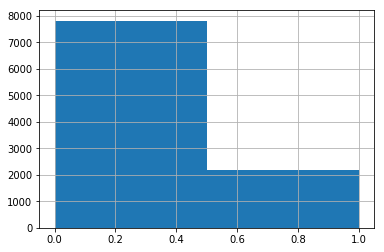

In [9]:
synthesized['type'].hist(bins=2, range=[0, 1])

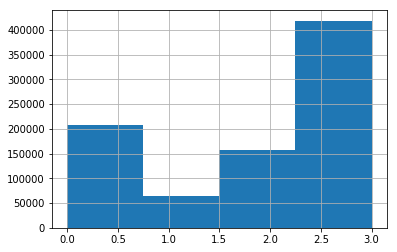

In [10]:
data['operation'].hist(bins=4, range=[0, 3])

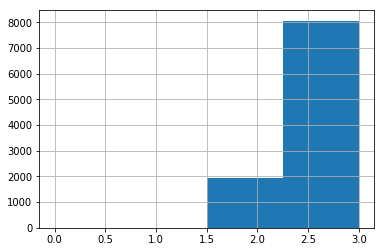

In [11]:
synthesized['operation'].hist(bins=4, range=[0, 3])

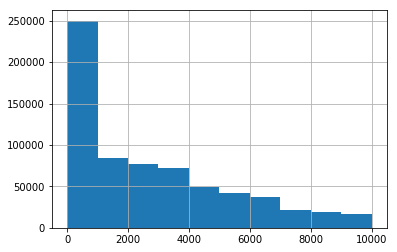

In [12]:
data['amount'].hist(bins=10, range=[0.0, 10000.0])

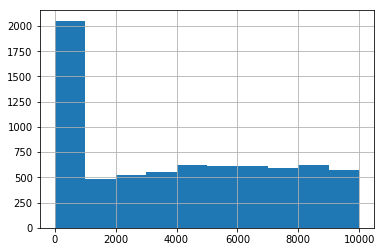

In [13]:
synthesized['amount'].hist(bins=10, range=[0.0, 10000.0])

# Tests to confirm the utility of synthetic data 

In [14]:
from synthesized.testing.testing_environment import estimate_utility, compare_marginal_distributions
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [15]:
estimate_utility(
    df_orig=data, df_synth=synthesized,
    continuous_columns=['amount'],  categorical_columns=['type', 'operation'],
    classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor()
)

,target_column,estimator,baseline_original_score,original_score,baseline_synth_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,amount,DecisionTreeRegressor,0.000000,0.199652,0.000000,0.185267,8.174275e+07,8.321187e+07,0.927953,0.982345
1,operation,DecisionTreeClassifier,0.487432,0.976312,0.487432,0.518598,9.140262e-02,2.594374e+00,0.063750,0.035231
2,type,DecisionTreeClassifier,0.741016,1.000000,0.741016,0.788008,0.000000e+00,2.119924e-01,0.181445,0.000000


In [16]:
compare_marginal_distributions(data, synthesized, target_column='operation', filter_column='amount')

,filter,column,emd
0,amount < 21850.0,operation,0.899135
1,amount < 43700.0,operation,0.880927
2,amount < 65550.0,operation,0.880155
3,amount < 87400.0,operation,0.880590
